In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 500
import scipy.stats as stats


#simple image scaling to (nR x nC) size
def scale(im, nR, nC):
    nR0 = len(im)     # source number of rows 
    nC0 = len(im[0])  # source number of columns 
    blockSizeR = int(np.ceil(nR0/nR))
    blockSizeC = int(np.ceil(nC0/nC))
    
    if nR0 >= nR and nC0 >= nC:

        outarray = np.zeros((nR,nC))

        for r in range(nR):
            for c in range(nC):
                if blockSizeR*(r+1) > nR0 - 1:
                    stopR = nR0
                else:
                    stopR = blockSizeR*(r+1)
                if blockSizeC*(c+1) > nC0 - 1:
                    stopC = nC0
                else:
                    stopC = blockSizeC*(c+1) 

                outarray[r,c] = np.sum(im[blockSizeR*r:stopR,blockSizeC*c:stopC])
        return outarray
    else:
        print("image can only be downsampled")
        return im
def objectiveFunc(t,p,goodInd):
#     trel = [t[x] for x in goodInd]
#     prel = [p[x] for x in goodInd]
#     return -1*np.corrcoef(trel,prel)[0,1]
    return np.sum(np.square(np.subtract(t,p)))

def ISAFit(T,N,P,func,goodInd,x_init = np.random.random((2,1)),plot=False):
    sol = opt.minimize(lambda x: objectiveFunc(P,func(x[0],x[1],[xx/np.sum(x[2:]) for xx in x[2:]],N,P),goodInd),x0=np.concatenate((x_init,T),axis=None),
                       bounds=[(0,1) for _ in range(len(x_init) + len(T))])
    g,D = sol.x[:2]
    T = sol.x[2:]
    err = sol.fun
    P_pred = func(g,D,T,N,P)
    x_ind = 0
    x_lab = []
    i = 0
    if plot:
        for p,pp in zip(P,P_pred):
            plt.bar([x_ind,x_ind+1],[p,pp])
            x_lab.append([x_ind+.5,"M+" + str(i)])
            x_ind += 4
            i += 1
        plt.xticks([x[0] for x in x_lab],[x[1] for x in x_lab],rotation=90)

        plt.figure()

        #plot solution curves
        D_test = np.linspace(0,1,25)
        for pp in range(len(P)):
            g_test = []
            for d in D_test:
                sol = opt.minimize(lambda x: abs(P[pp]-func(x[0],d,T,N,P)[pp]),x0=[g])
                g_test.append(sol.x[0])
            plt.plot(D_test,g_test,c="black")

        plt.scatter([D],[g],color="red")
        plt.ylim((0,1))
        plt.xlabel("D")
        plt.ylabel("g(t)")
    return g,D,T,err,P_pred
    

def myristicISA(g,D,T,N,P):

    #define tracer and naturual abundance isotopomers
    N0 = N[0]
    N1 = N[1]
    N2 = N[2]
    T0 = T[0]
    T1 = T[1]
    T2 = T[2]
    
    #compute X values
    X0 = D*T0 + (1-D)*N0
    X1 = D*T1 + (1-D)*N1
    X2 = D*T2 + (1-D)*N2

    #compute product isotopmer abundances
    P = [g*(X0**7)+(1-g)*(N0**7),
            g*(7*(X0**6)*X1)+(1-g)*(7*(N0**6)*N1),
            g*(21*(X0**5)*(X1**2)+7*(X0**6)*X2)+(1-g)*(21*(N0**5)*(N1**2)+7*(N0**6)*N2),
            g*(35*X0**4*X1**3+42*X0**5*X1*X2)+(1-g)*(35*N0**4*N1**3+42*N0**5*N1*N2),
            g*(35*X0**3*X1**4+105*X0**4*X1**2*X2+21*X0**5*X2**2)+(1-g)*(35*N0**3*N1**4+105*N0**4*N1**2*N2+21*N0**5*N2**2),
            g*(21*X0**2*X1**5+140*X0**3*X1**3*X2+105*X0**4*X1*X2**2)+(1-g)*(21*N0**2*N1**5+140*N0**3*N1**3*N2+105*N0**4*N1*N2**2),
            g*(7*X0*X1**6+105*X0**2*X1**4*X2+210*X0**3*X1**2*X2**2+35*X0**4*X2**3)+(1-g)*(7*N0*N1**6+105*N0**2*N1**4*N2+210*N0**3*N1**2*N2**2+35*N0**4*N2**3),
            g*(X1**7+42*X0*X1**5*X2+210*X0**2*X1**3*X2**2+140*X0**3*X1*X2**3)+(1-g)*(N1**7+42*N0*N1**5*N2+210*N0**2*N1**3*N2**2+140*N0**3*N1*N2**3),
            g*(7*X1**6*X2+105*X0*X1**4*X2**2+210*X0**2*X1**2*X2**3+35*X0**3*X2**4)+(1-g)*(7*N1**6*N2+105*N0*N1**4*N2**2+210*N0**2*N1**2*N2**3+35*N0**3*N2**4),
            g*(21*X1**5*X2**2+140*X0*X1**3*X2**3+105*X0**2*X1*X2**4)+(1-g)*(21*N1**5*N2**2+140*N0*N1**3*N2**3+105*N0**2*N1*N2**4),
            g*(35*X1**4*X2**3+105*X0*X1**2*X2**4+21*X0**2*X2**5)+(1-g)*(35*N1**4*N2**3+105*N0*N1**2*N2**4+21*N0**2*N2**5),
            g*(35*(X1**3)*(X2**4)+42*X0*X1*(X2**5))+(1-g)*(35*(N1**3)*(N2**4)+42*N0*N1*N2**5),
            g*(21*X1**2*(X2**5)+7*X0*(X2**6)) + (1-g)*(21*(N1**2)*(N2**5)+7*N0*(N2**6)),
            g*(7*X1*(X2**6))+(1-g)*(7*N1*(N2**6)),
            g*(X2**7)+(1-g)*(N2**7)]
    
    return P

def stearicISA(g,D,T,N,P):

    #define tracer and naturual abundance isotopomers
    N0 = N[0]
    N1 = N[1]
    N2 = N[2]
    T0 = T[0]
    T1 = T[1]
    T2 = T[2]
    
    #compute X values
    X0 = D*T0 + (1-D)*N0
    X1 = D*T1 + (1-D)*N1
    X2 = D*T2 + (1-D)*N2

    #compute product isotopmer abundances

    P = [g*(X0**9)+(1-g)*(N0**9),
      g*(9*X0**8*X1)+(1-g)*(9*N0**8*N1),
      g*(9*X0**8*X2+36*X0**7*X1**2)+(1-g)*(9*N0**8*N2+36*N0**7*N1**2),
      g*(72*X0**7*X1*X2+84*X0**6*X1**3)+(1-g)*(72*N0**7*N1*N2+84*N0**6*N1**3),
      g*(36*X0**7*X2**2+252*X0**6*X1**2*X2+126*X0**5*X1**4)+(1-g)*(36*N0**7*N2**2+252*N0**6*N1**2*N2+126*N0**5*N1**4),
      g*(252*X0**6*X1*X2**2+504*X0**5*X1**3*X2+126*X0**4*X1**5)+(1-g)*(252*N0**6*N1*N2**2+504*N0**5*N1**3*N2+126*N0**4*N1**5),
      g*(84*X0**6*X2**3+756*X0**5*X1**2*X2**2+630*X0**4*X1**4*X2+84*X0**3*X1**6)+(1-g)*(84*N0**6*N2**3+756*N0**5*N1**2*N2**2+630*N0**4*N1**4*N2+84*N0**3*N1**6),
      g*(504*X0**5*X1*X2**3+1260*X0**4*X1**3*X2**2+504*X0**3*X1**5*X2+36*X0**2*X1**7)+(1-g)*(504*N0**5*N1*N2**3+1260*N0**4*N1**3*N2**2+504*N0**3*N1**5*N2+36*N0**2*N1**7),
      g*(126*X0**5*X2**4+1260*X0**4*X1**2*X2**3+1260*X0**3*X1**4*X2**2+252*X0**2*X1**6*X2+9*X0*X1**8)+(1-g)*(126*N0**5*N2**4+1260*N0**4*N1**2*N2**3+1260*N0**3*N1**4*N2**2+252*N0**2*N1**6*N2+9*N0*N1**8),
      g*(630*X0**4*X1*X2**4+1680*X0**3*X1**3*X2**3+756*X0**2*X1**5*X2**2+72*X0*X1**7*X2+X1**9)+(1-g)*(630*N0**4*N1*N2**4+1680*N0**3*N1**3*N2**3+756*N0**2*N1**5*N2**2+72*N0*N1**7*N2+N1**9),
      g*(126*X0**4*X2**5+1260*X0**3*X1**2*X2**4+1260*X0**2*X1**4*X2**3+252*X0*X1**6*X2**2+9*X1**8*X2)+(1-g)*(126*N0**4*N2**5+1260*N0**3*N1**2*N2**4+1260*N0**2*N1**4*N2**3+252*N0*N1**6*N2**2+9*N1**8*N2),
      g*(504*X0**3*X1*X2**5+1260*X0**2*X1**3*X2**4+504*X0*X1**5*X2**3+36*X1**7*X2**2)+(1-g)*(504*N0**3*N1*N2**5+1260*N0**2*N1**3*N2**4+504*N0*N1**5*N2**3+36*N1**7*N2**2),
      g*(84*X0**3*X2**6+756*X0**2*X1**2*X2**5+630*X0*X1**4*X2**4+84*X1**6*X2**3)+(1-g)*(84*N0**3*N2**6+756*N0**2*N1**2*N2**5+630*N0*N1**4*N2**4+84*N1**6*N2**3),
      g*(252*X0**2*X1*X2**6+504*X0*X1**3*X2**5+126*X1**5*X2**4)+(1-g)*(252*N0**2*N1*N2**6+504*N0*N1**3*N2**5+126*N1**5*N2**4),
      g*(36*X0**2*X2**7+252*X0*X1**2*X2**6+126*X1**4*X2**5)+(1-g)*(36*N0**2*N2**7+252*N0*N1**2*N2**6+126*N1**4*N2**5),
      g*(72*X0*X1*X2**7+84*X1**3*X2**6)+(1-g)*(72*N0*N1*N2**7+84*N1**3*N2**6),
      g*(9*X0*X2**8+36*X1**2*X2**7)+(1-g)*(9*N0*N2**8+36*N1**2*N2**7),
      g*(9*X1*X2**8)+(1-g)*(9*N1*N2**8),
      g*(X2**9)+(1-g)*(N2**9)]

    return P

def palmitateISA(g,D,T,N,P):

    #define tracer and naturual abundance isotopomers
    N0 = N[0]
    N1 = N[1]
    N2 = N[2]
    T0 = T[0]
    T1 = T[1]
    T2 = T[2]
    
    #compute X values
    X0 = D*T0 + (1-D)*N0
    X1 = D*T1 + (1-D)*N1
    X2 = D*T2 + (1-D)*N2

    #compute product isotopmer abundances

    P = [g*(X0**8)+(1-g)*(N0**8),
         g*(8*X0**7*X1)+(1-g)*(8*N0**7*N1),
         g*(8*X0**7*X2+28*X0**6*X1**2)+(1-g)*(8*N0**7*N2+28*N0**6*N1**2),
         g*(56*X0**6*X1*X2+56*X0**5*X1**3)+(1-g)*(56*N0**6*N1*N2+56*N0**5*N1**3),
         g*(28*X0**6*X2**2+168*X0**5*X1**2*X2+70*X0**4*X1**4)+(1-g)*(28*N0**6*N2**2+168*N0**5*N1**2*N2+70*N0**4*N1**4),
         g*(168*X0**5*X1*X2**2+280*X0**4*X1**3*X2+56*X0**3*X1**5)+(1-g)*(168*N0**5*N1*N2**2+280*N0**4*N1**3*N2+56*N0**3*N1**5),
         g*(56*X0**5*X2**3+420*X0**4*X1**2*X2**2+280*X0**3*X1**4*X2+28*X0**2*X1**6)+(1-g)*(56*N0**5*N2**3+420*N0**4*N1**2*N2**2+280*N0**3*N1**4*N2+28*N0**2*N1**6),
         g*(280*X0**4*X1*X2**3+560*X0**3*X1**3*X2**2+168*X0**2*X1**5*X2+8*X0*X1**7)+(1-g)*(280*N0**4*N1*N2**3+560*N0**3*N1**3*N2**2+168*N0**2*N1**5*N2+8*N0*N1**7),
         g*(70*X0**4*X2**4+560*X0**3*X1**2*X2**3+420*X0**2*X1**4*X2**2+56*X0*X1**6*X2+X1**8)+(1-g)*(70*N0**4*N2**4+560*N0**3*N1**2*N2**3+420*N0**2*N1**4*N2**2+56*N0*N1**6*N2+N1**8),
         g*(280*X0**3*X1*X2**4+560*X0**2*X1**3*X2**3+168*X0*X1**5*X2**2+8*X1**7*X2)+(1-g)*(280*N0**3*N1*N2**4+560*N0**2*N1**3*N2**3+168*N0*N1**5*N2**2+8*N1**7*N2),
         g*(56*X0**3*X2**5+420*X0**2*X1**2*X2**4+280*X0*X1**4*X2**3+28*X1**6*X2**2)+(1-g)*(56*N0**3*N2**5+420*N0**2*N1**2*N2**4+280*N0*N1**4*N2**3+28*N1**6*N2**2),
         g*(168*X0**2*X1*X2**5+280*X0*X1**3*X2**4+56*X1**5*X2**3)+(1-g)*(168*N0**2*N1*N2**5+280*N0*N1**3*N2**4+56*N1**5*N2**3),
         g*(28*X0**2*X2**6+168*X0*X1**2*X2**5+70*X1**4*X2**4)+(1-g)*(28*N0**2*N2**6+168*N0*N1**2*N2**5+70*N1**4*N2**4),
         g*(56*X0*X1*X2**6+56*X1**3*X2**5)+(1-g)*(56*N0*N1*N2**6+56*N1**3*N2**5),
         g*(8*X0*X2**7+28*X1**2*X2**6)+(1-g)*(8*N0*N2**7+28*N1**2*N2**6),
         g*(8*X1*X2**7)+(1-g)*(8*N1*N2**7),
         g*(X2**8)+(1-g)*(N2**8)]

    return P


In [115]:
filename = "20200228_mouse_liver_13C_nontumor6 Analyte 3SRD19.txt"
nrows = 60
ncols = 120
numCarbons = 16
m0Mz = 256.24023 
adductChange = -1.007276
ppmThresh = 20
func = palmitateISA

In [116]:
data = [r.strip().split() for r in open(filename,"r").readlines()[3:]]
data = {(x[0],float(x[1]),float(x[2])):{mz:float(i) for mz,i in zip(data[0],x[3:])} for x in data[1:] if len(x) > 0}
data = pd.DataFrame.from_dict(data,orient="index")
cols = data.columns.values
mzs = cols


In [117]:

mzsOI = [m0Mz+adductChange+1.00336*x for x in range(numCarbons+1)]
mzMatchDict = {i:{"true":m,"observed":[],"matched":False} for m,i in zip(mzsOI,range(len(mzsOI)))}
for m,i in zip(mzsOI,range(len(mzsOI))):
    matched = False
    for m2 in mzs:
        tmpM2 = float(m2)
        if abs(m-tmpM2) / m * 1e6 < ppmThresh:
            mzMatchDict[i]["observed"].append(m2)
            mzMatchDict[i]["matched"] = True
            matched = True
            break
    if not matched:
        print("missed",m)
    else:
        print("found",m,mzMatchDict[i]["observed"])


found 255.232954 ['255.2307']
found 256.236314 ['256.2320']
missed 257.239674
missed 258.243034
found 259.246394 ['259.2420']
found 260.249754 ['260.2459']
found 261.253114 ['261.2495']
found 262.256474 ['262.2534']
found 263.259834 ['263.2564']
found 264.263194 ['264.2599']
found 265.266554 ['265.2625']
found 266.269914 ['266.2654']
found 267.273274 ['267.2681']
found 268.276634 ['268.2721']
found 269.279994 ['269.2756']
found 270.28335400000003 ['270.2821']
found 271.286714 ['271.2851']


In [118]:
tensor = []
for mz in range(numCarbons+1):
    if mzMatchDict[mz]["matched"]:
        picDict = {}
        for index,row in data.iterrows():
            picDict[(index[2],index[1])] = np.sum([row[x] for x in mzMatchDict[mz]["observed"]])

        xcords = [float(y) for y in list(set([x[0] for x in picDict]))]
        ycords = [float(y) for y in list(set([x[1] for x in picDict]))]
        outarray = np.zeros((len(xcords),len(ycords)))
        if len(xcords) < nrows or len(ycords) < ncols:
            nrows = len(xcords)
            ncols = len(ycords)
        xcords.sort()
        ycords.sort()
        xcordMap = {x:i for x,i in zip(xcords,range(len(xcords)))}
        ycordMap = {x:i for x,i in zip(ycords,range(len(ycords)))}
        for [x,y],intens in picDict.items():
            outarray[xcordMap[float(x)],ycordMap[float(y)]] = intens
        outarray = scale(outarray,nrows,ncols)
    else:
        outarray = np.zeros((nrows,ncols))
    tensor.append(outarray)

tensor = np.array(tensor)

(array([2121.,  164.,  123.,  180.,  334.,  373.,  183.,   86.,   27.,
           9.]),
 array([   9006. ,  434645.9,  860285.8, 1285925.7, 1711565.6, 2137205.5,
        2562845.4, 2988485.3, 3414125.2, 3839765.1, 4265405. ]),
 <a list of 10 Patch objects>)

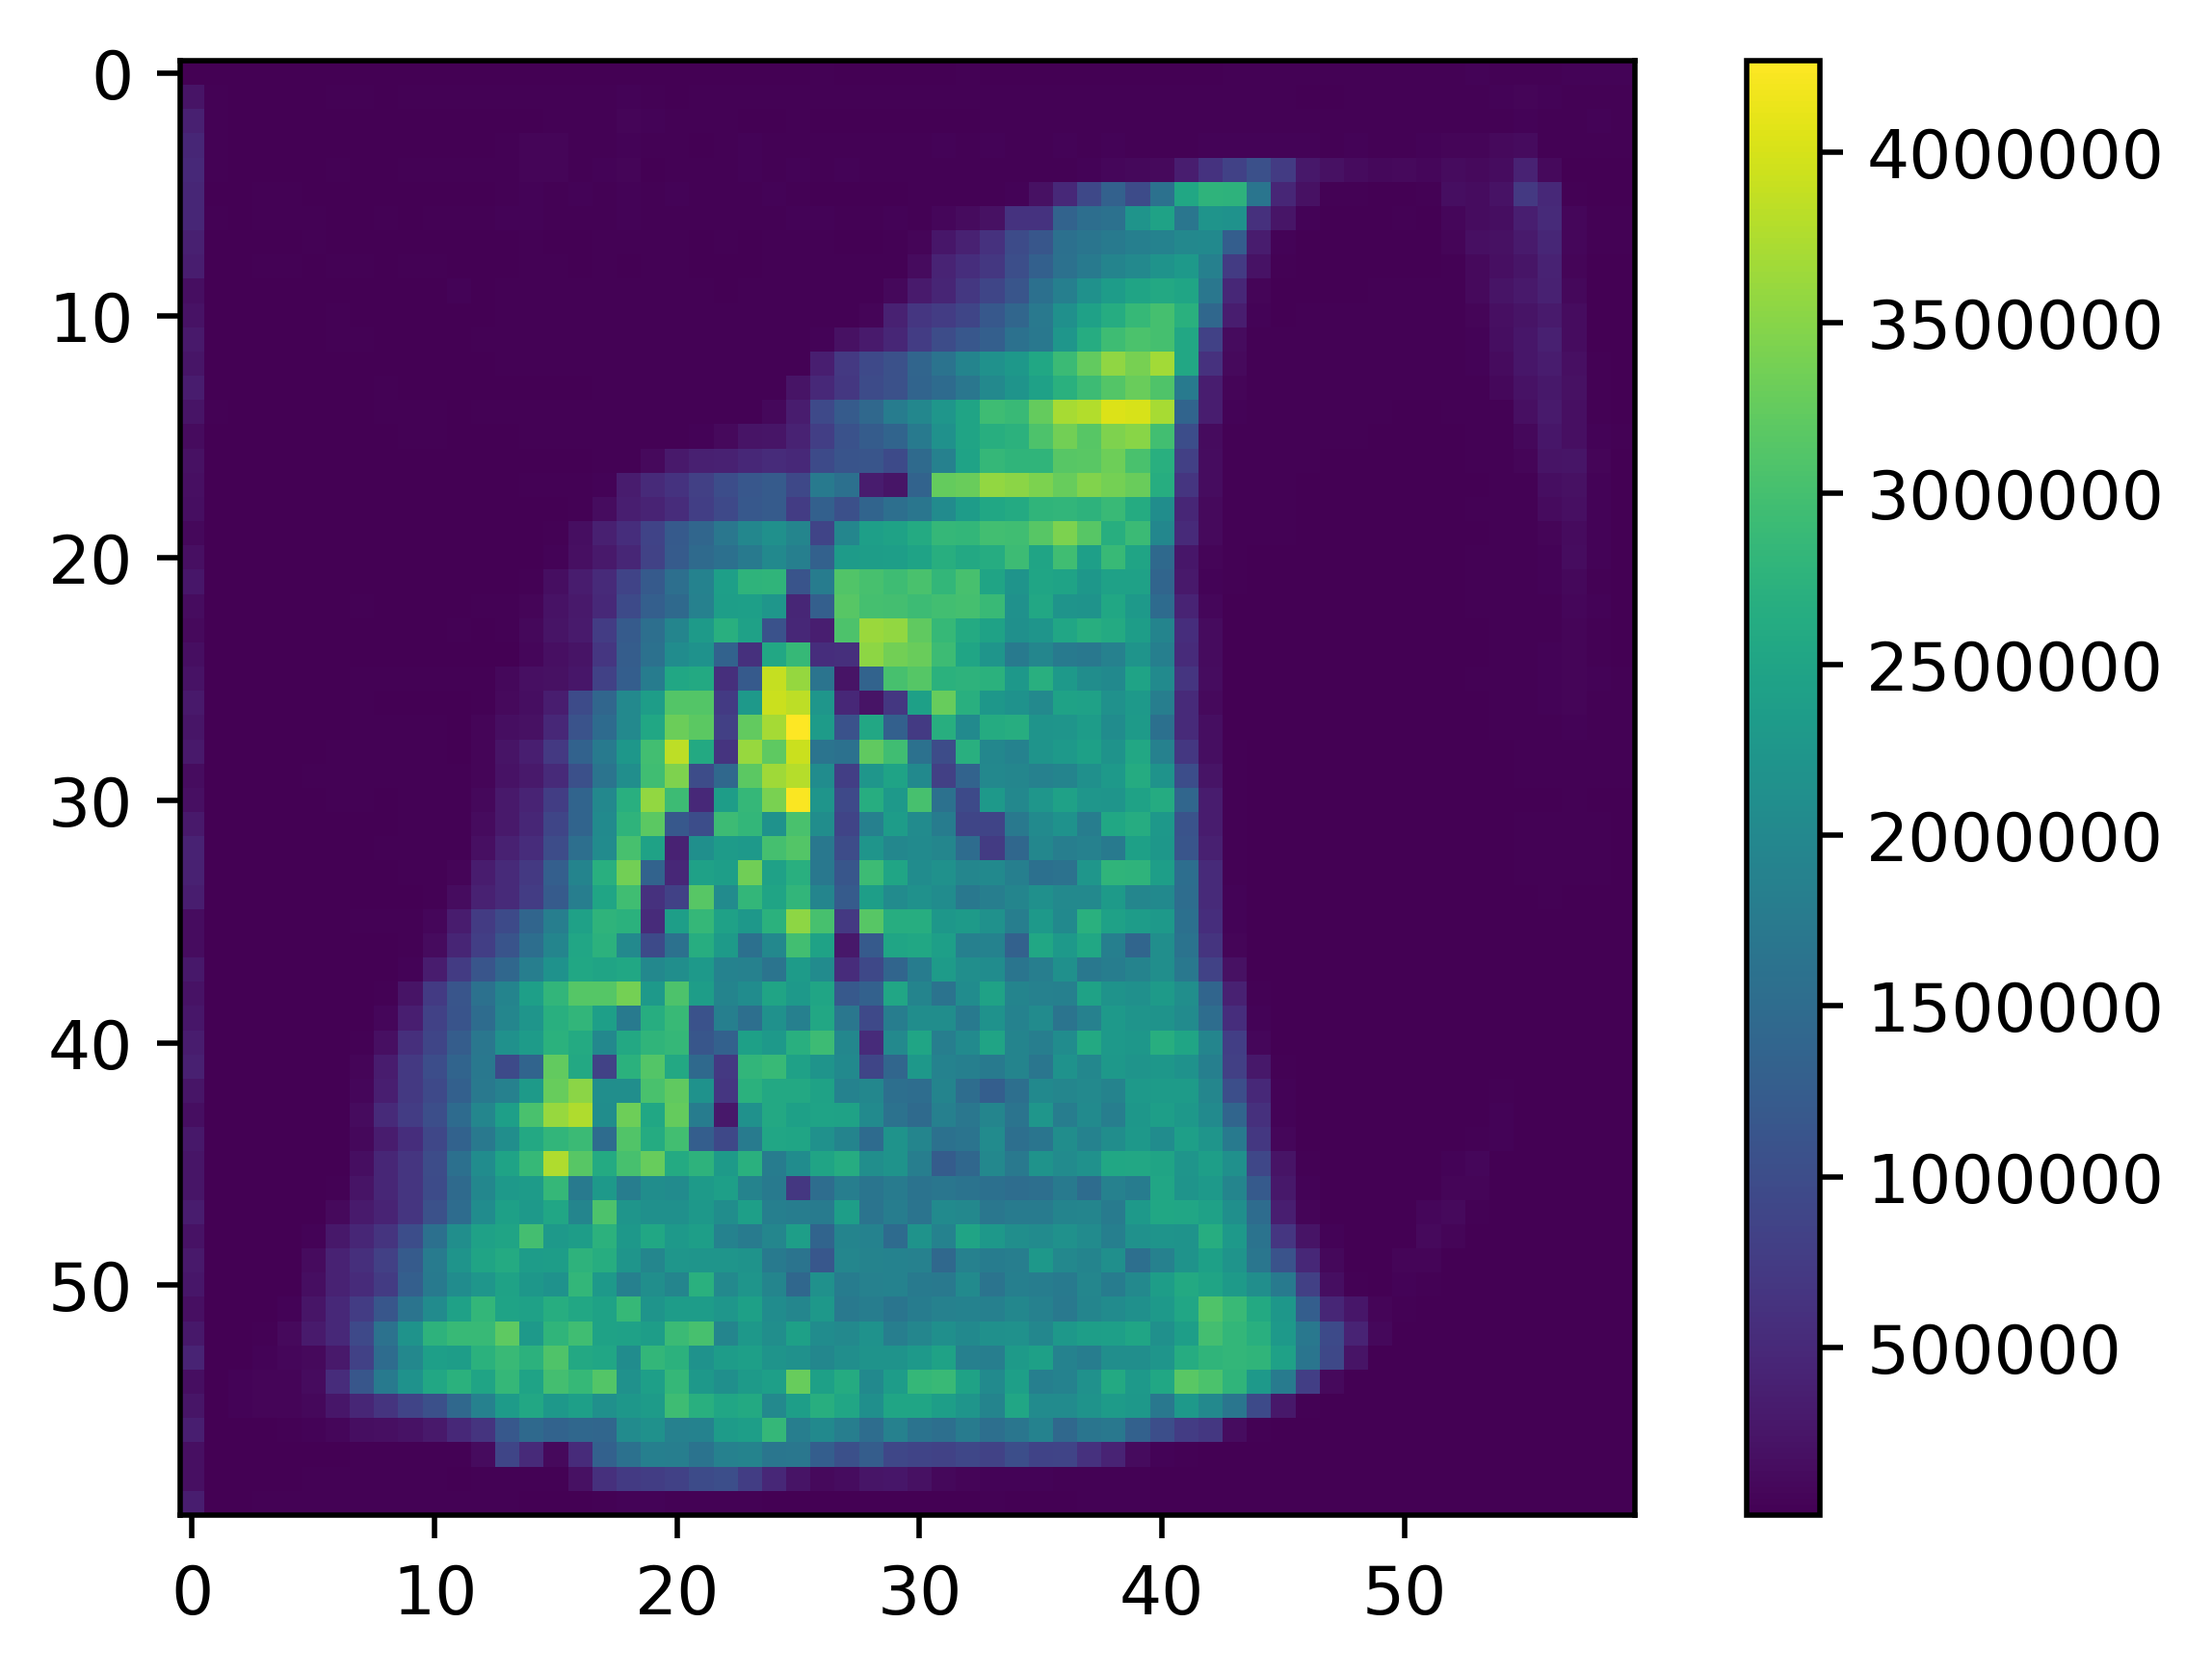

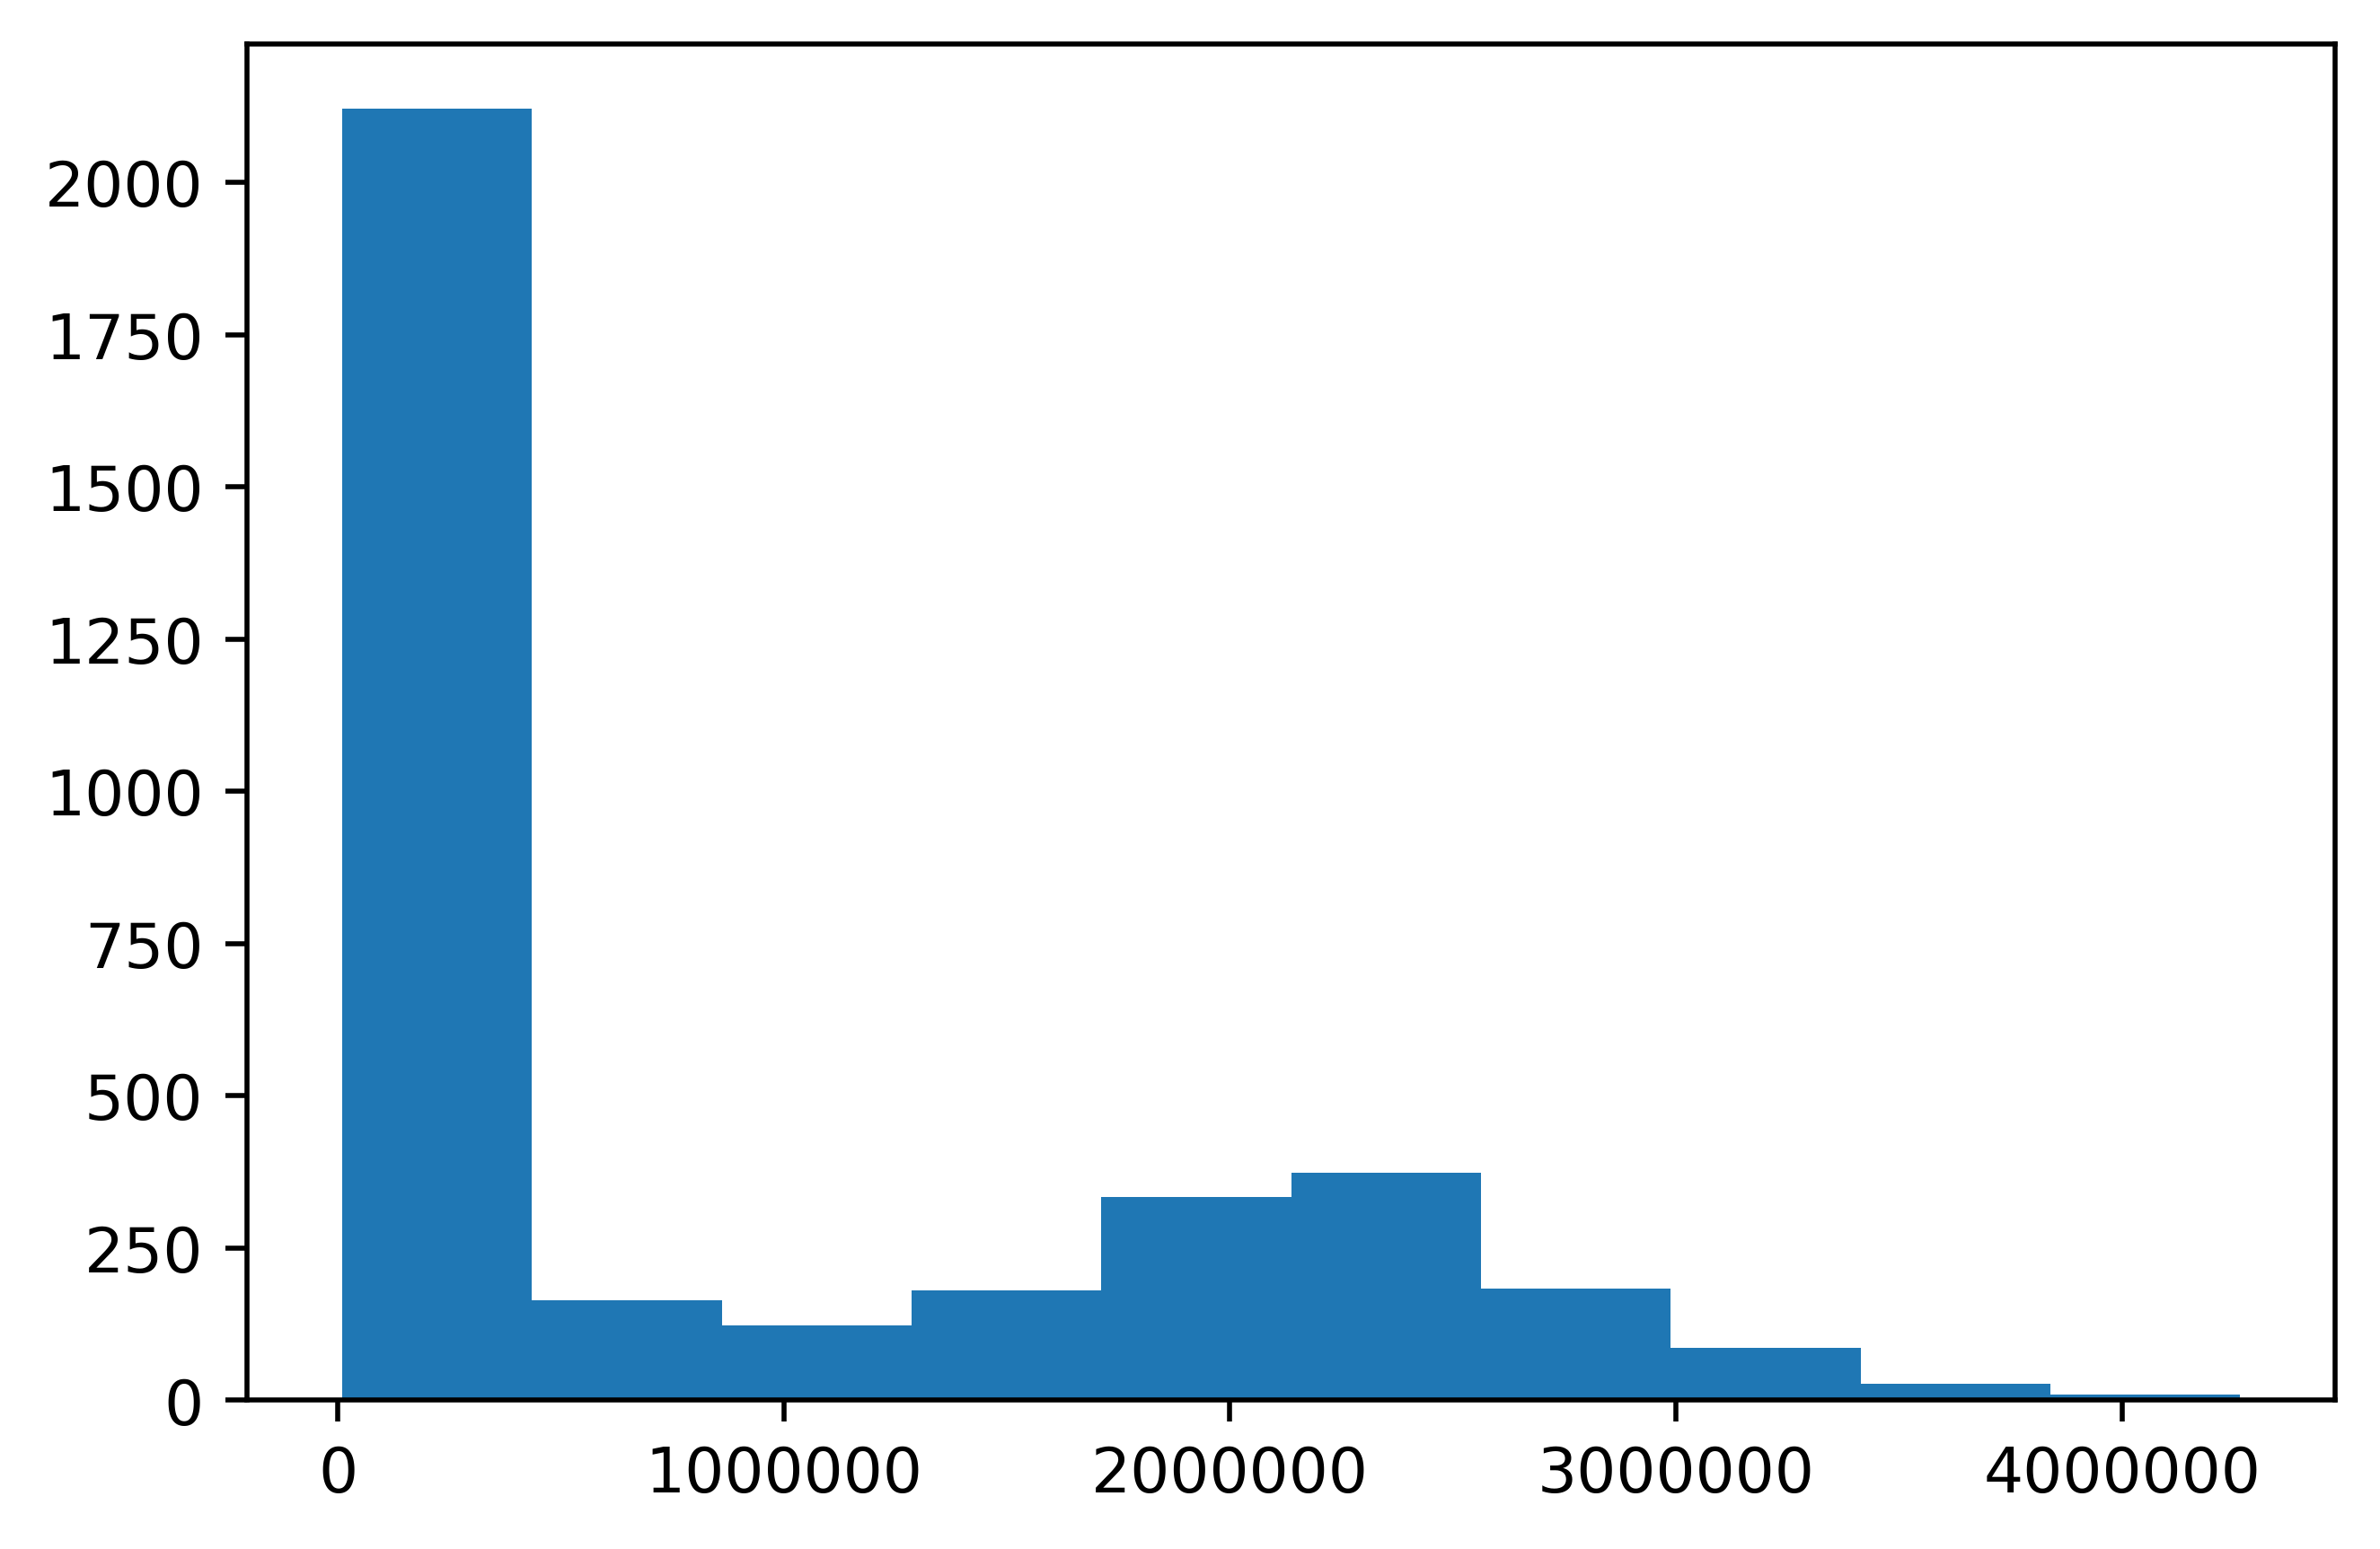

In [111]:
sumImage = np.zeros((nrows,ncols))
for mz in mzs:
    picDict = {}
    for index,row in data.iterrows():
        picDict[(index[2],index[1])] = row[mz]

    xcords = [float(y) for y in list(set([x[0] for x in picDict]))]
    ycords = [float(y) for y in list(set([x[1] for x in picDict]))]
    outarray = np.zeros((len(xcords),len(ycords)))
    if len(xcords) < nrows or len(ycords) < ncols:
        nrows = len(xcords)
        ncols = len(ycords)
    xcords.sort()
    ycords.sort()
    xcordMap = {x:i for x,i in zip(xcords,range(len(xcords)))}
    ycordMap = {x:i for x,i in zip(ycords,range(len(ycords)))}
    for [x,y],intens in picDict.items():
        outarray[xcordMap[float(x)],ycordMap[float(y)]] = intens
    outarray = scale(outarray,nrows,ncols)
    sumImage += outarray
    
plt.imshow(sumImage)
plt.colorbar()
plt.figure()
plt.hist(sumImage.flatten())

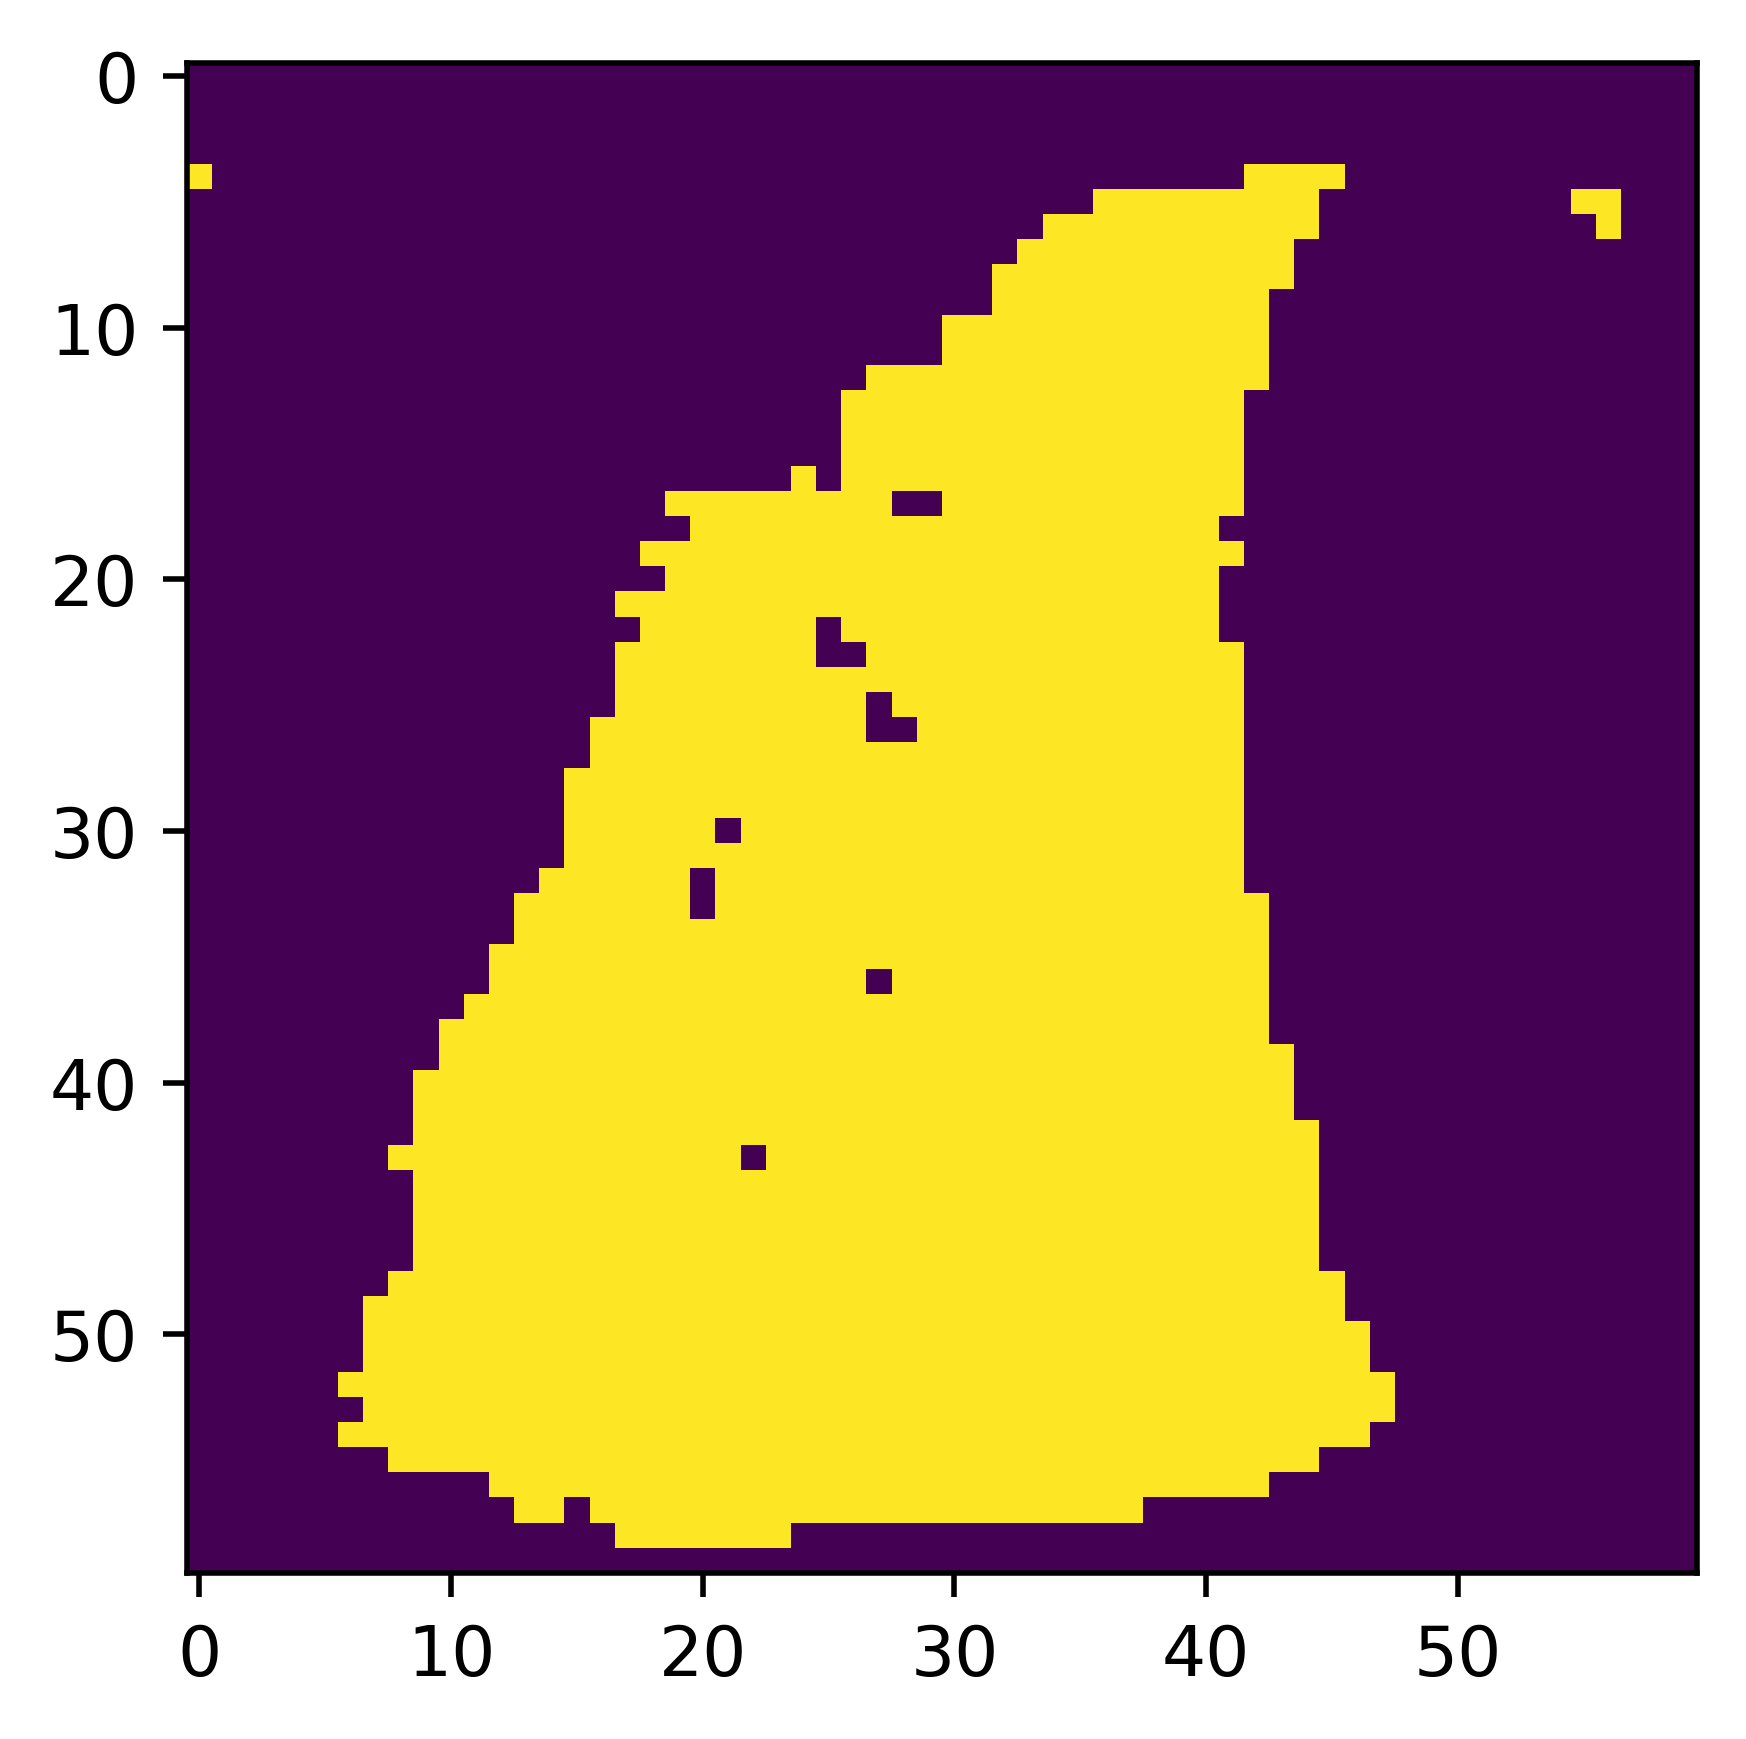

In [112]:
threshold = 5e5

imageBoundary = np.ones((nrows,ncols))
for r in range(nrows):
    for c in range(ncols):
        if sumImage[r,c] < threshold:
            imageBoundary[r,c] = 0
plt.imshow(imageBoundary)

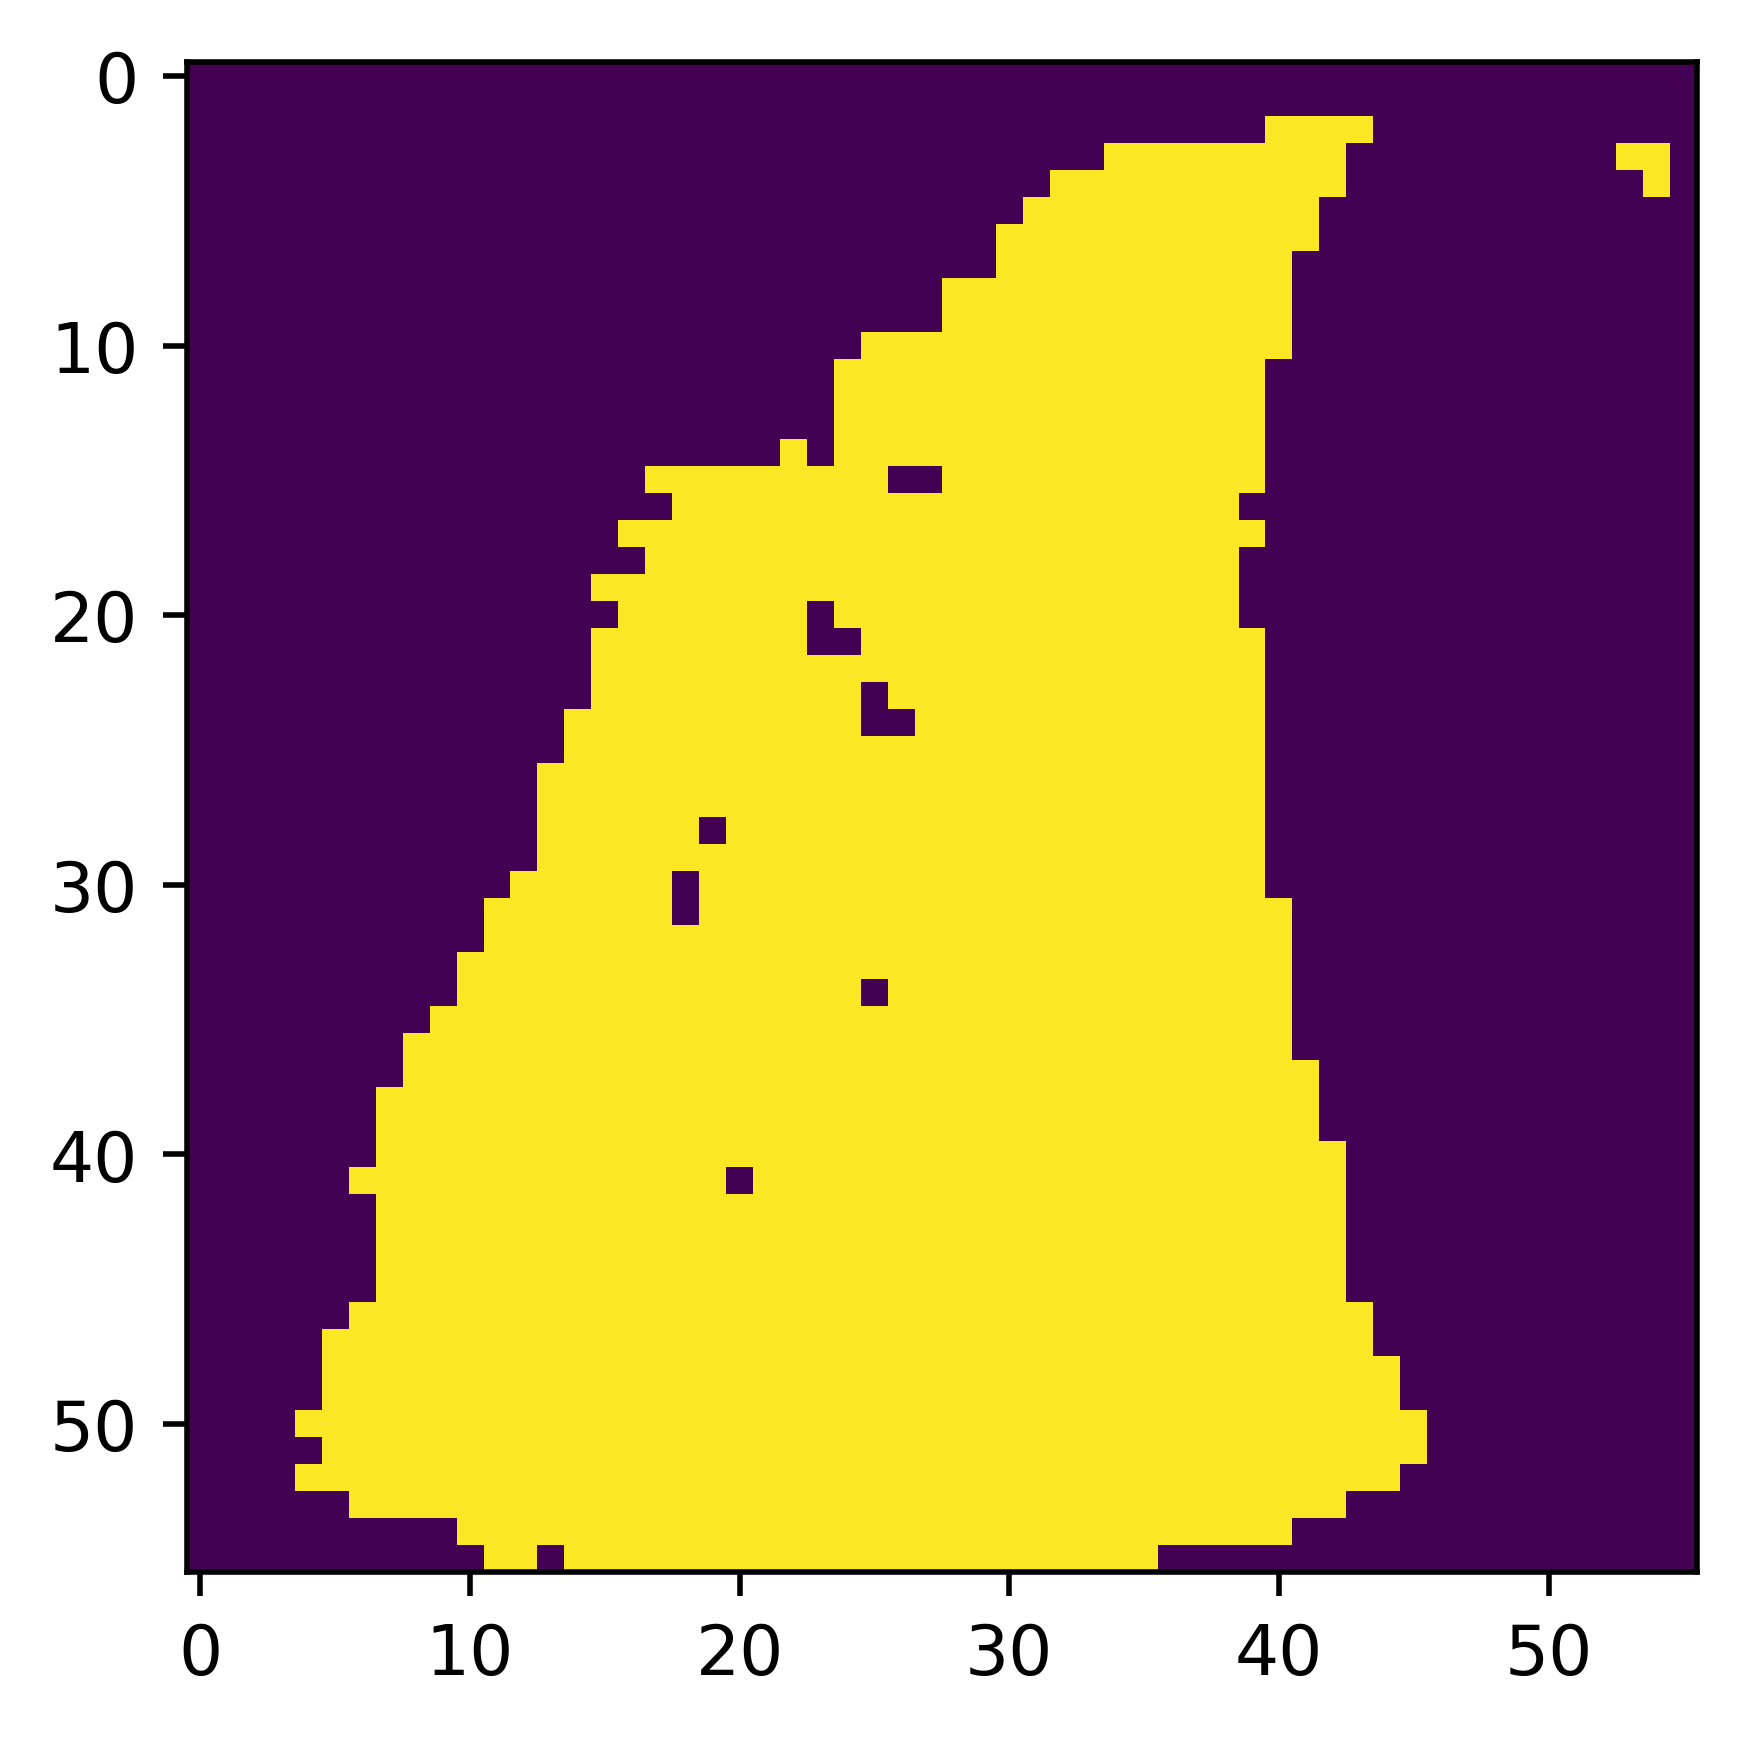

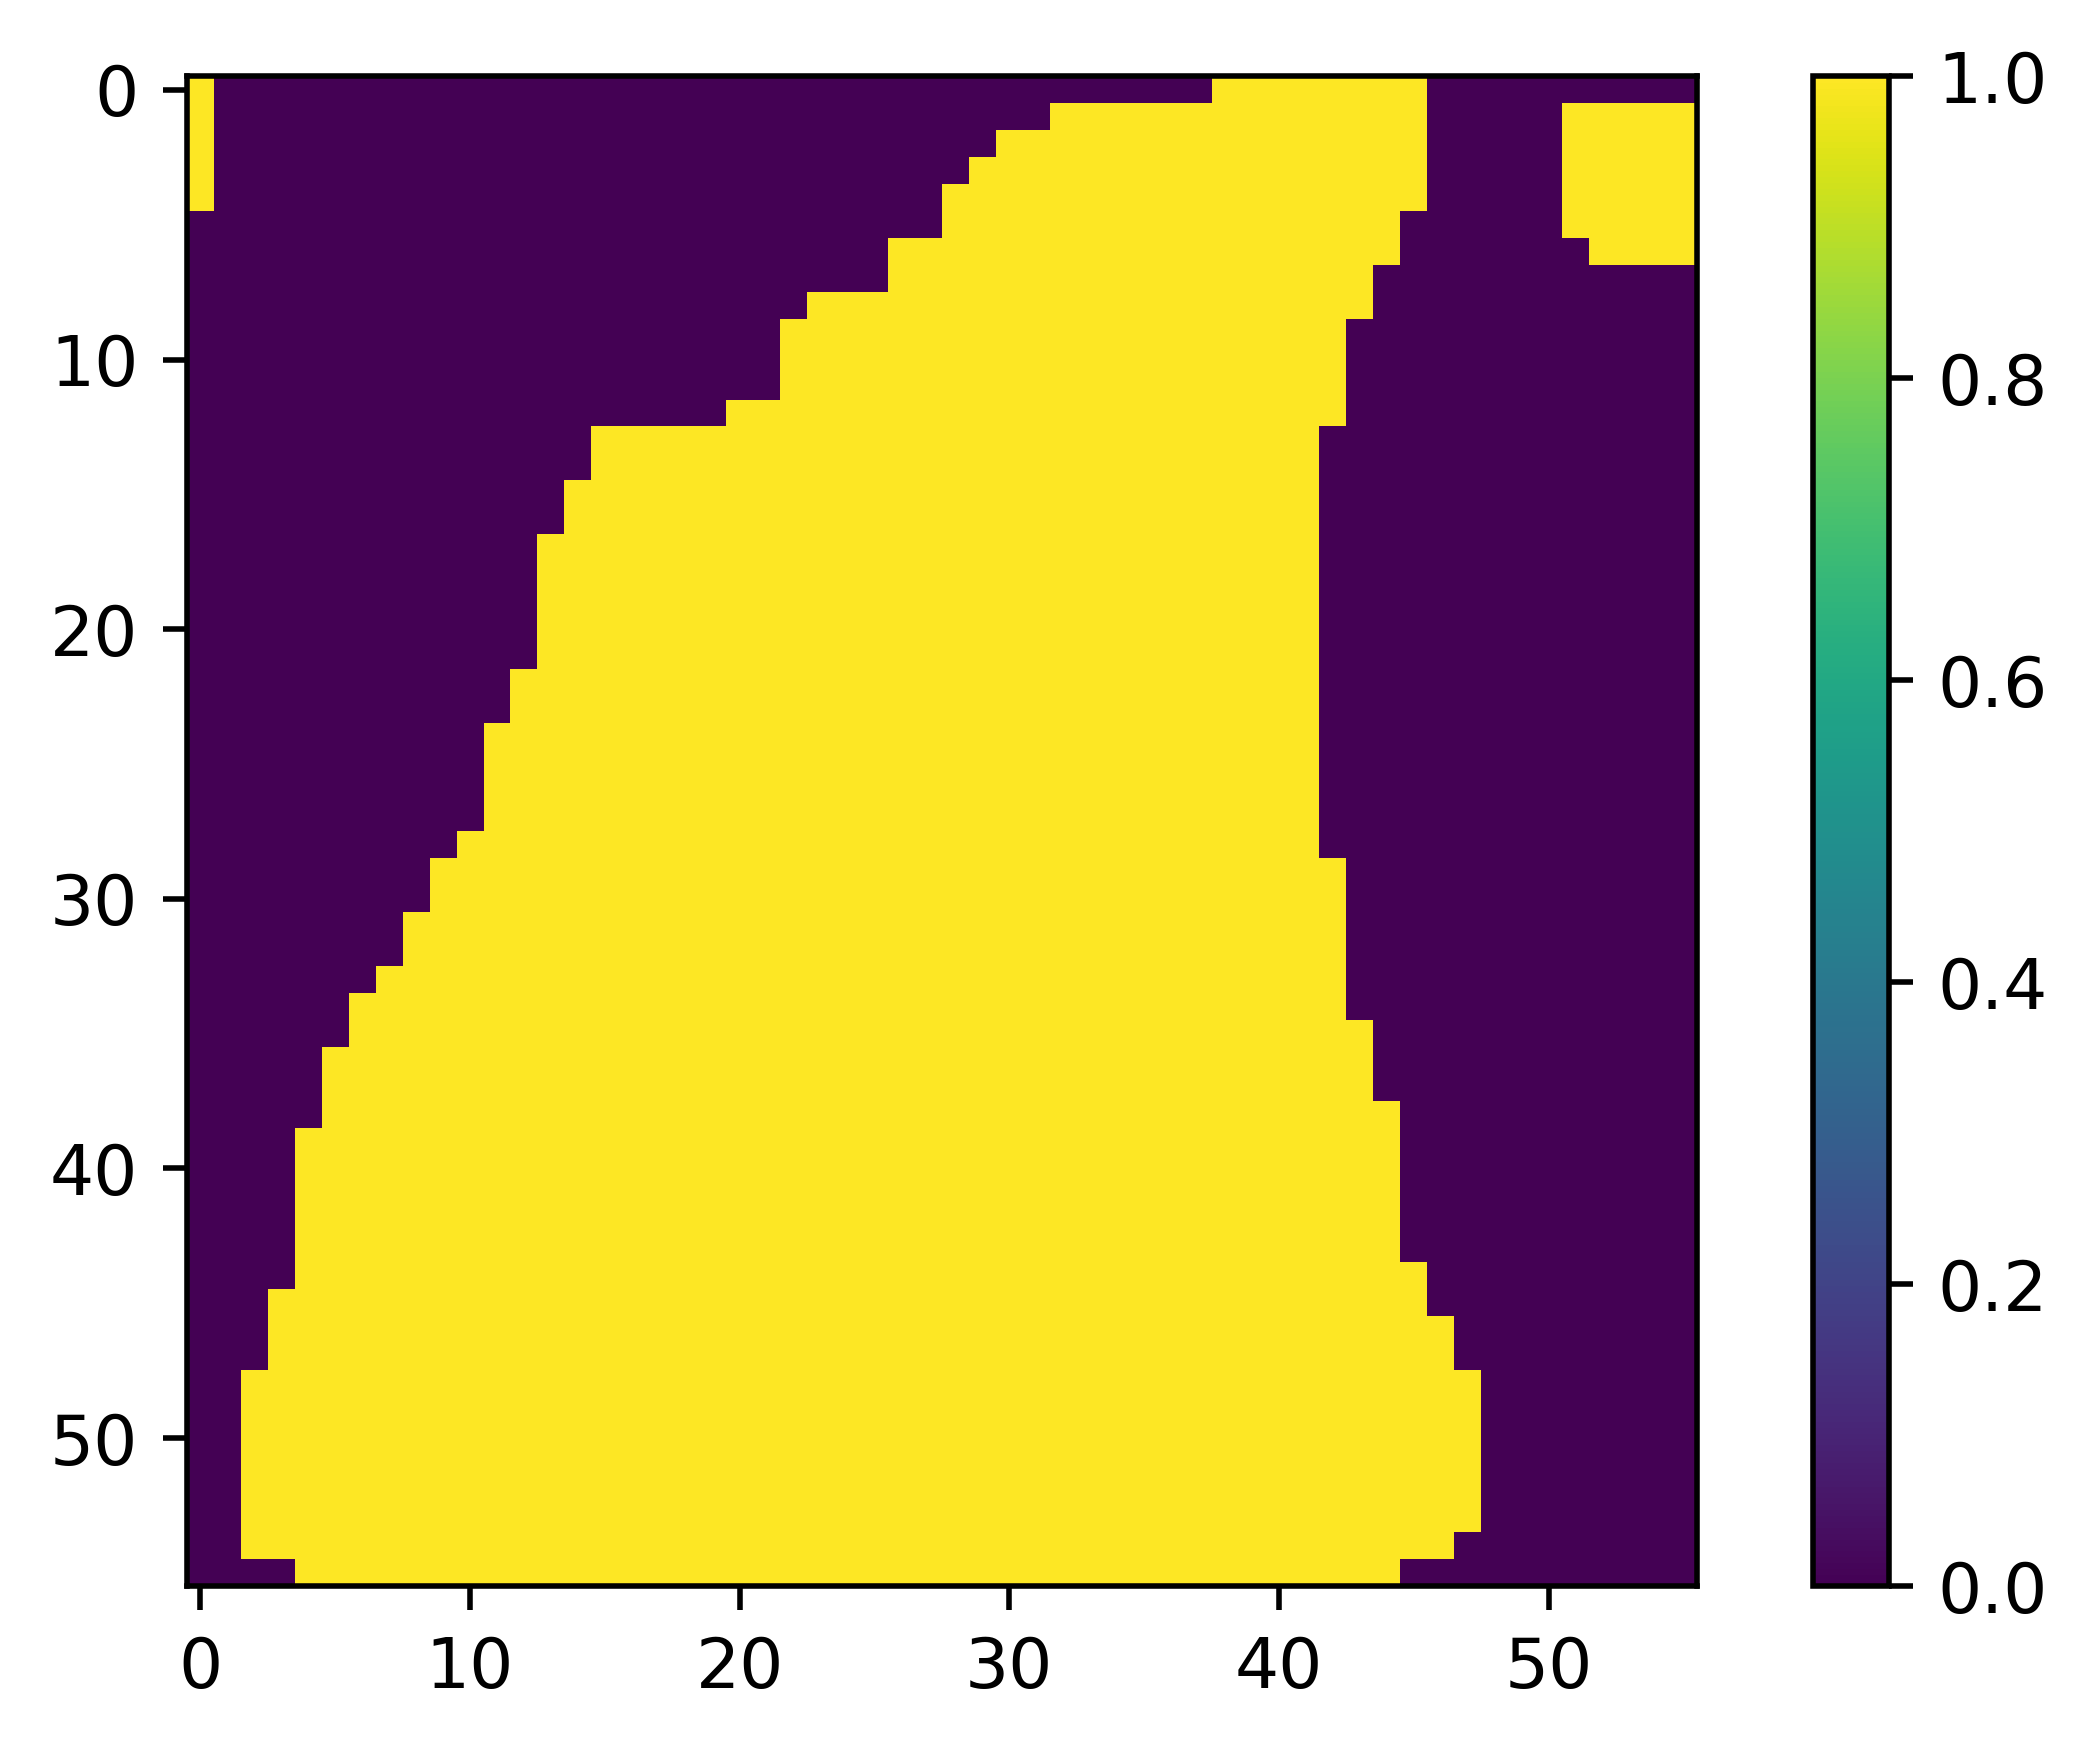

In [128]:
convSquare = 5
offset = int((convSquare-1)/2)
tensorFilt = np.zeros((len(tensor),nrows-2*offset,ncols-2*offset))
newImageBoundary = np.zeros((nrows-2*offset,ncols-2*offset))
for r in range(offset,nrows-offset):
    for c in range(offset,ncols-offset):
        newImageBoundary[r-offset:r+offset+1,c-offset:c+offset+1] = imageBoundary[r,c]
        for t in range(len(tensor)):
            tempMat = tensor[t,r-offset:r+offset+1,c-offset:c+offset+1]
            coef = imageBoundary[r-offset:r+offset+1,c-offset:c+offset+1]
            coef = coef / max([1,np.sum(coef)])
            tensorFilt[t,r-offset,c-offset] = np.sum(np.multiply(tempMat,coef))
plt.imshow(newImageBoundary)
plt.figure()

for r in range(len(tensorFilt[0])):
    for c in range(len(tensorFilt[0][0])):
        sumInt = np.sum(tensorFilt[:,r,c])
        tensorFilt[:,r,c] = tensorFilt[:,r,c]/max([1,sumInt])

plt.imshow(np.sum(tensorFilt,axis=0))
plt.colorbar()

[0.05333929 0.1567997  0.78986101]


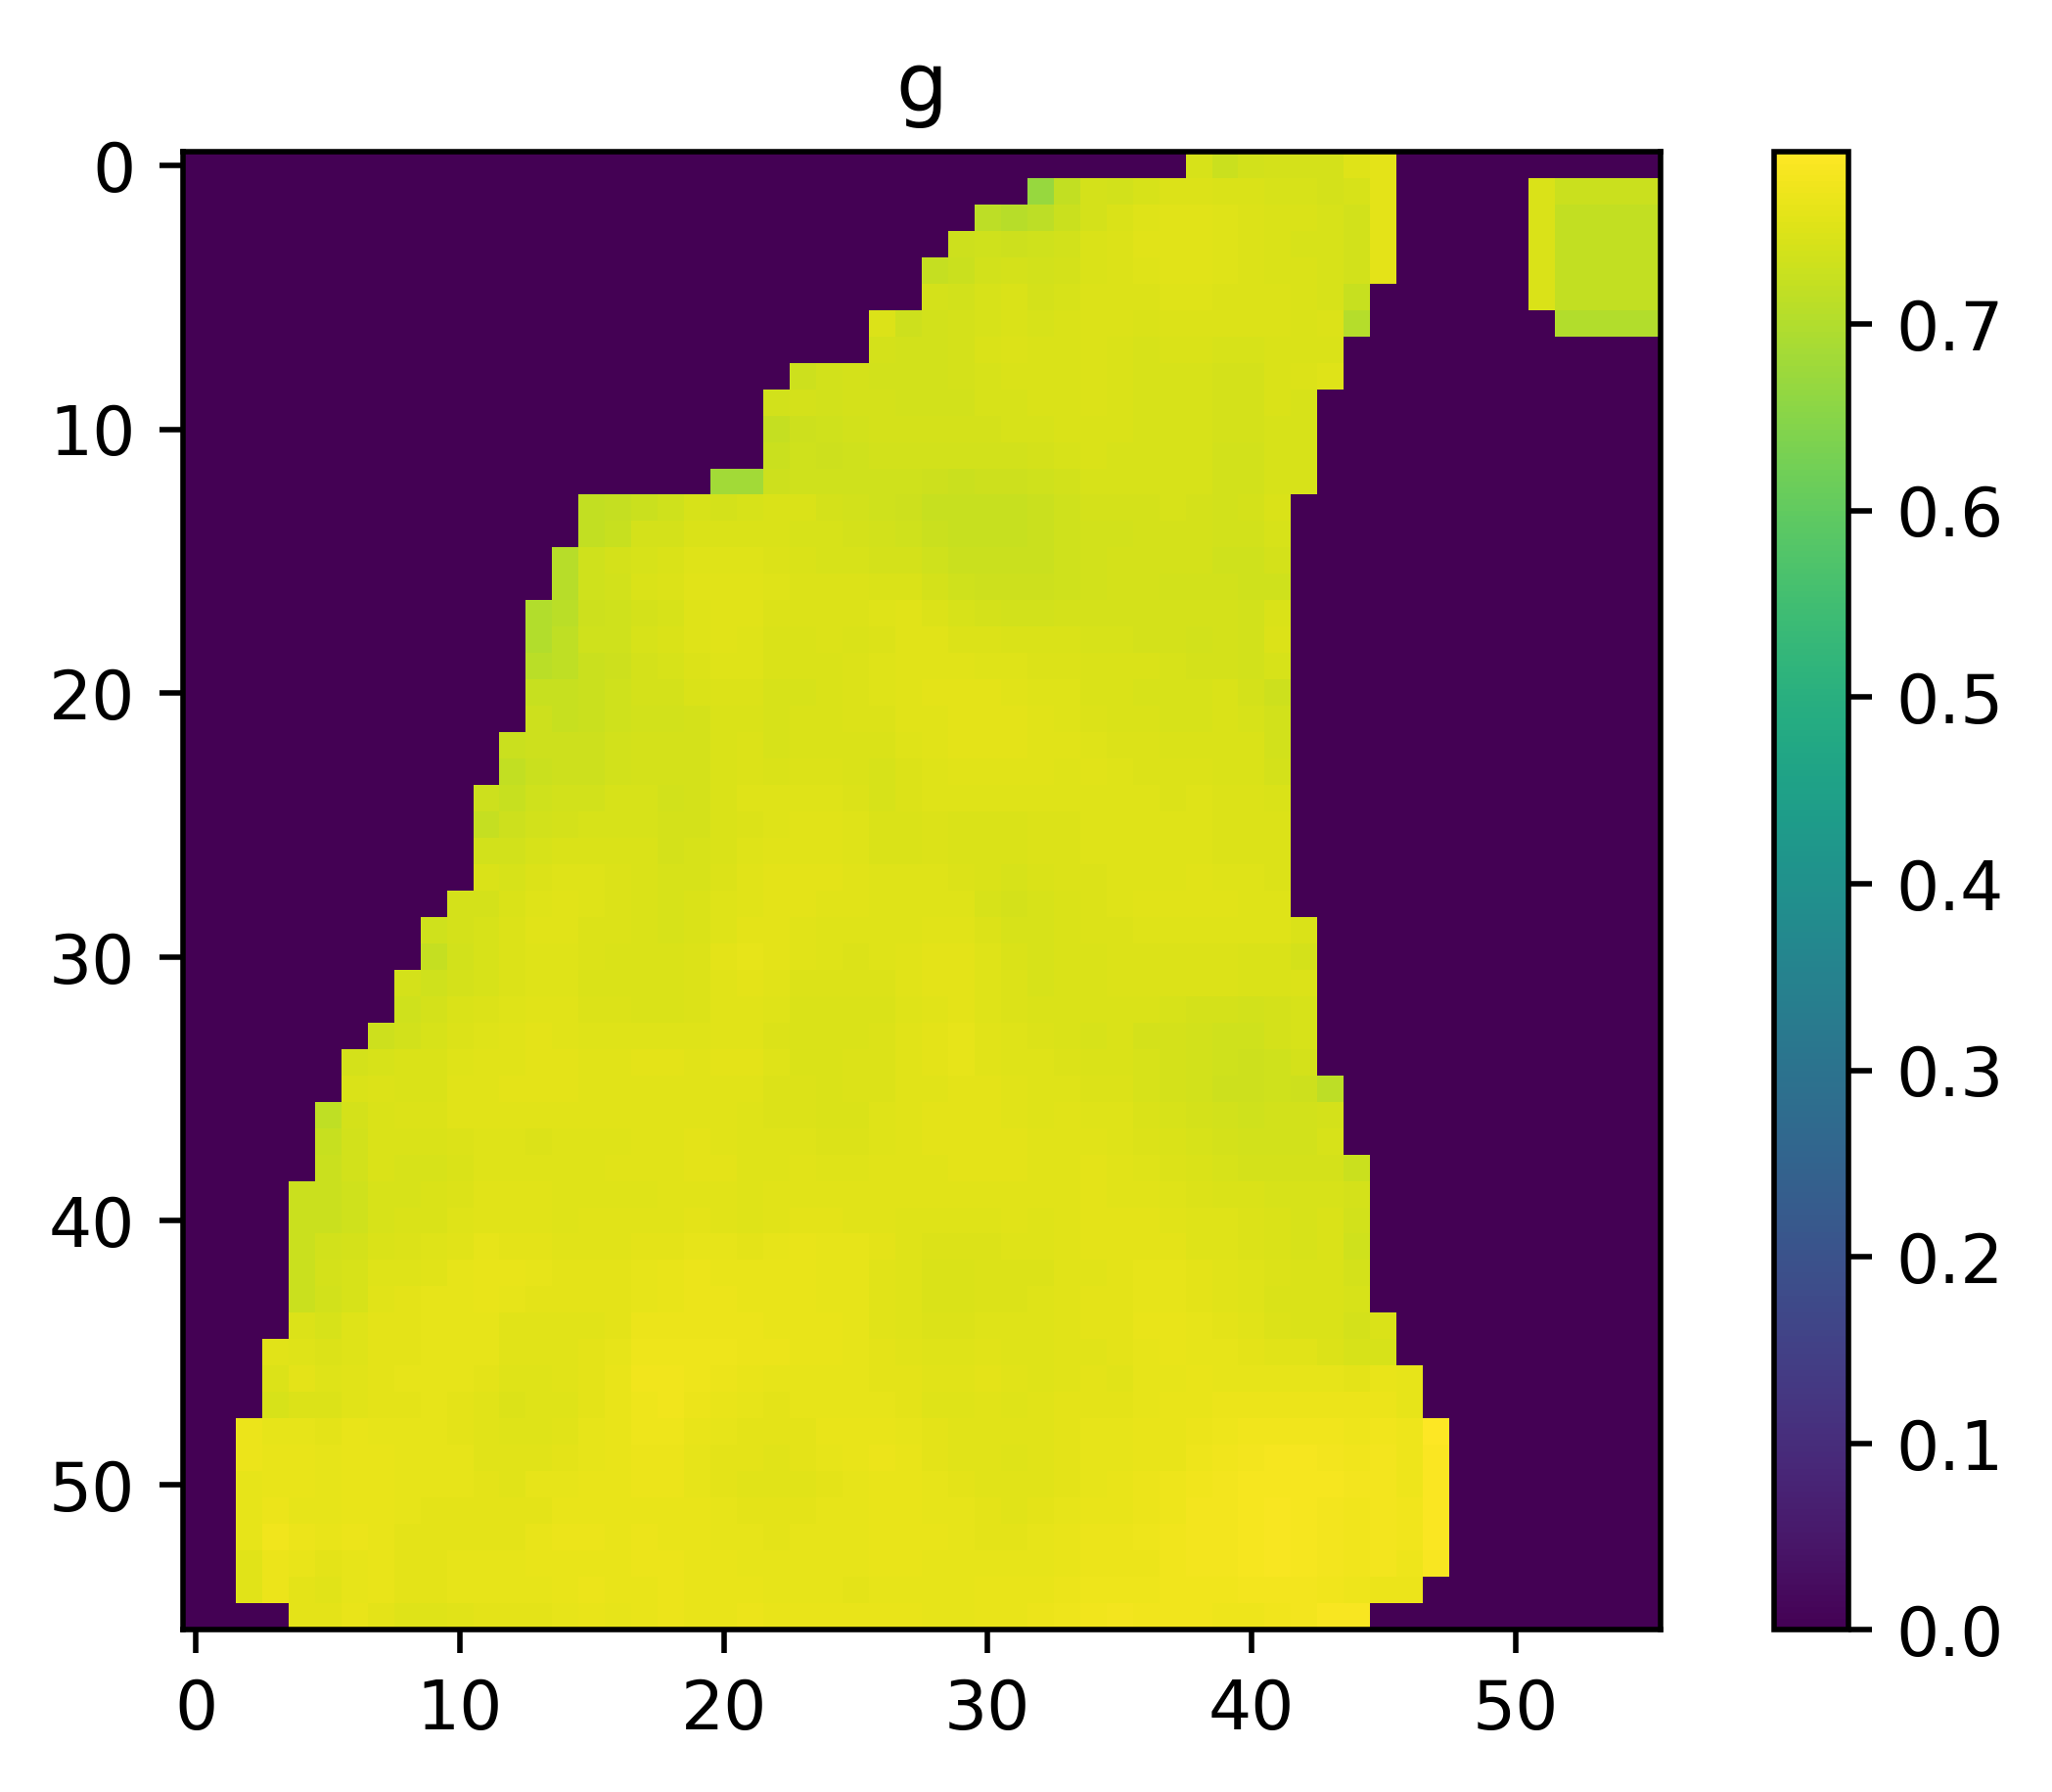

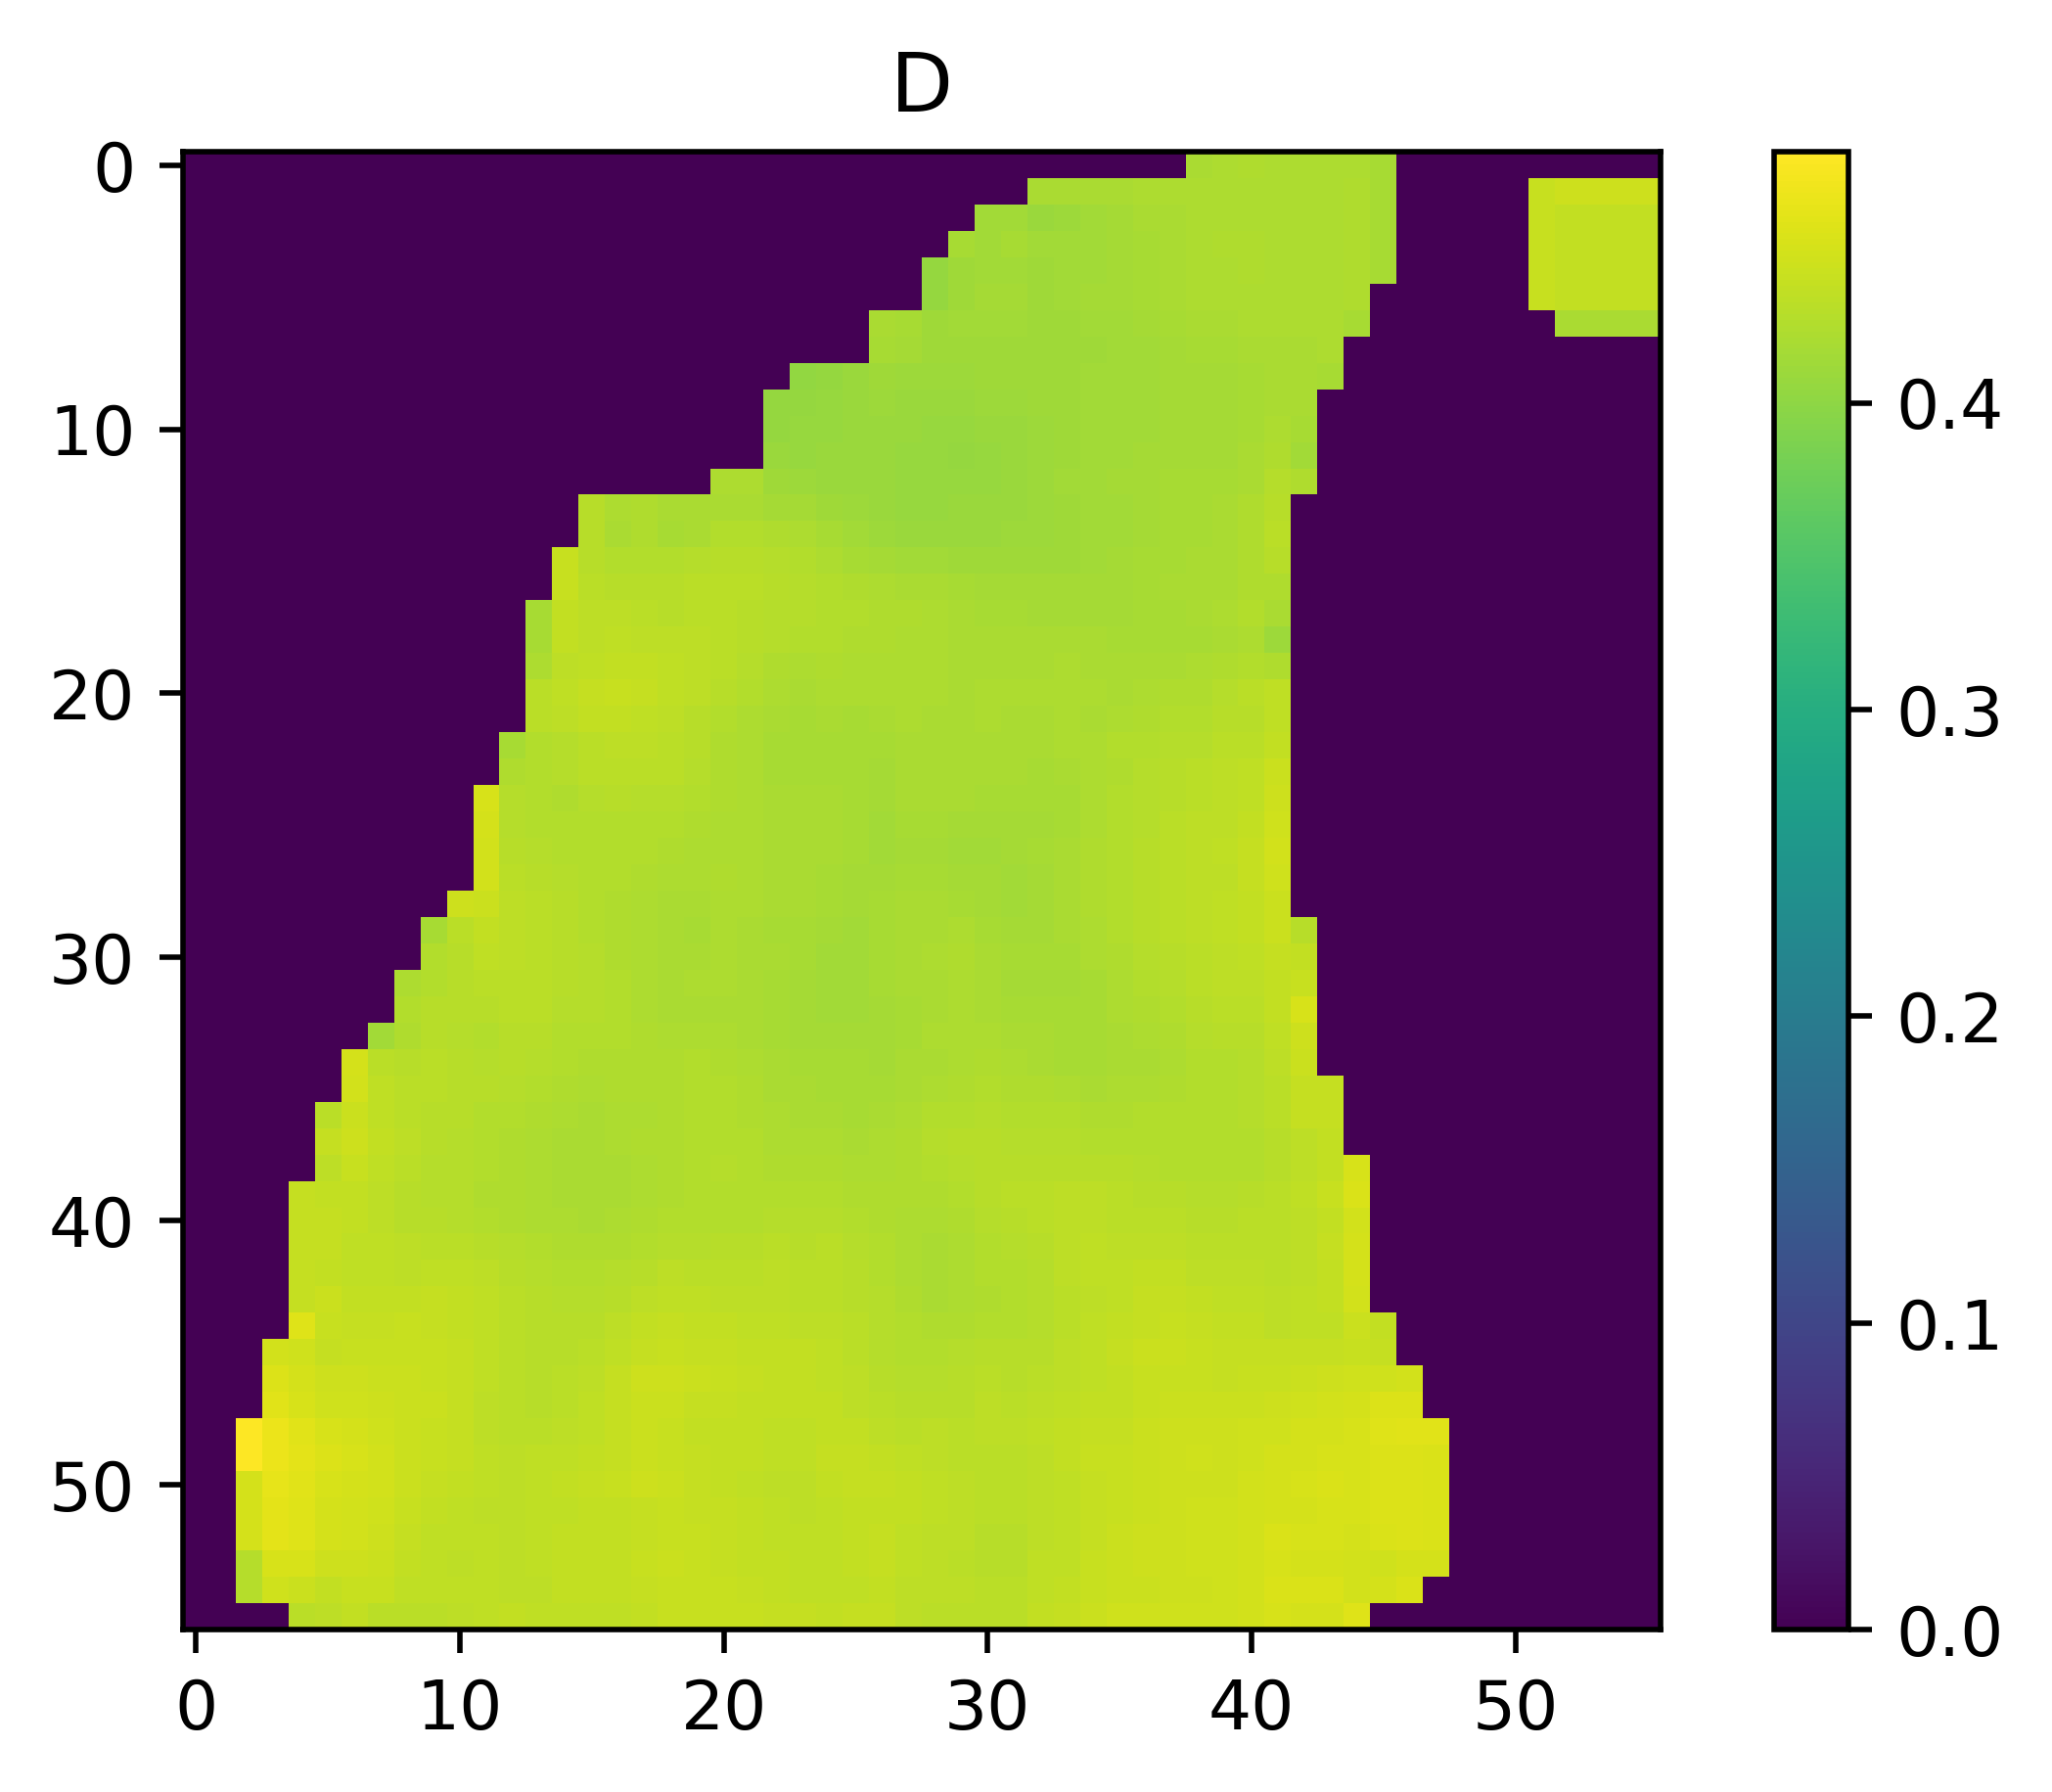

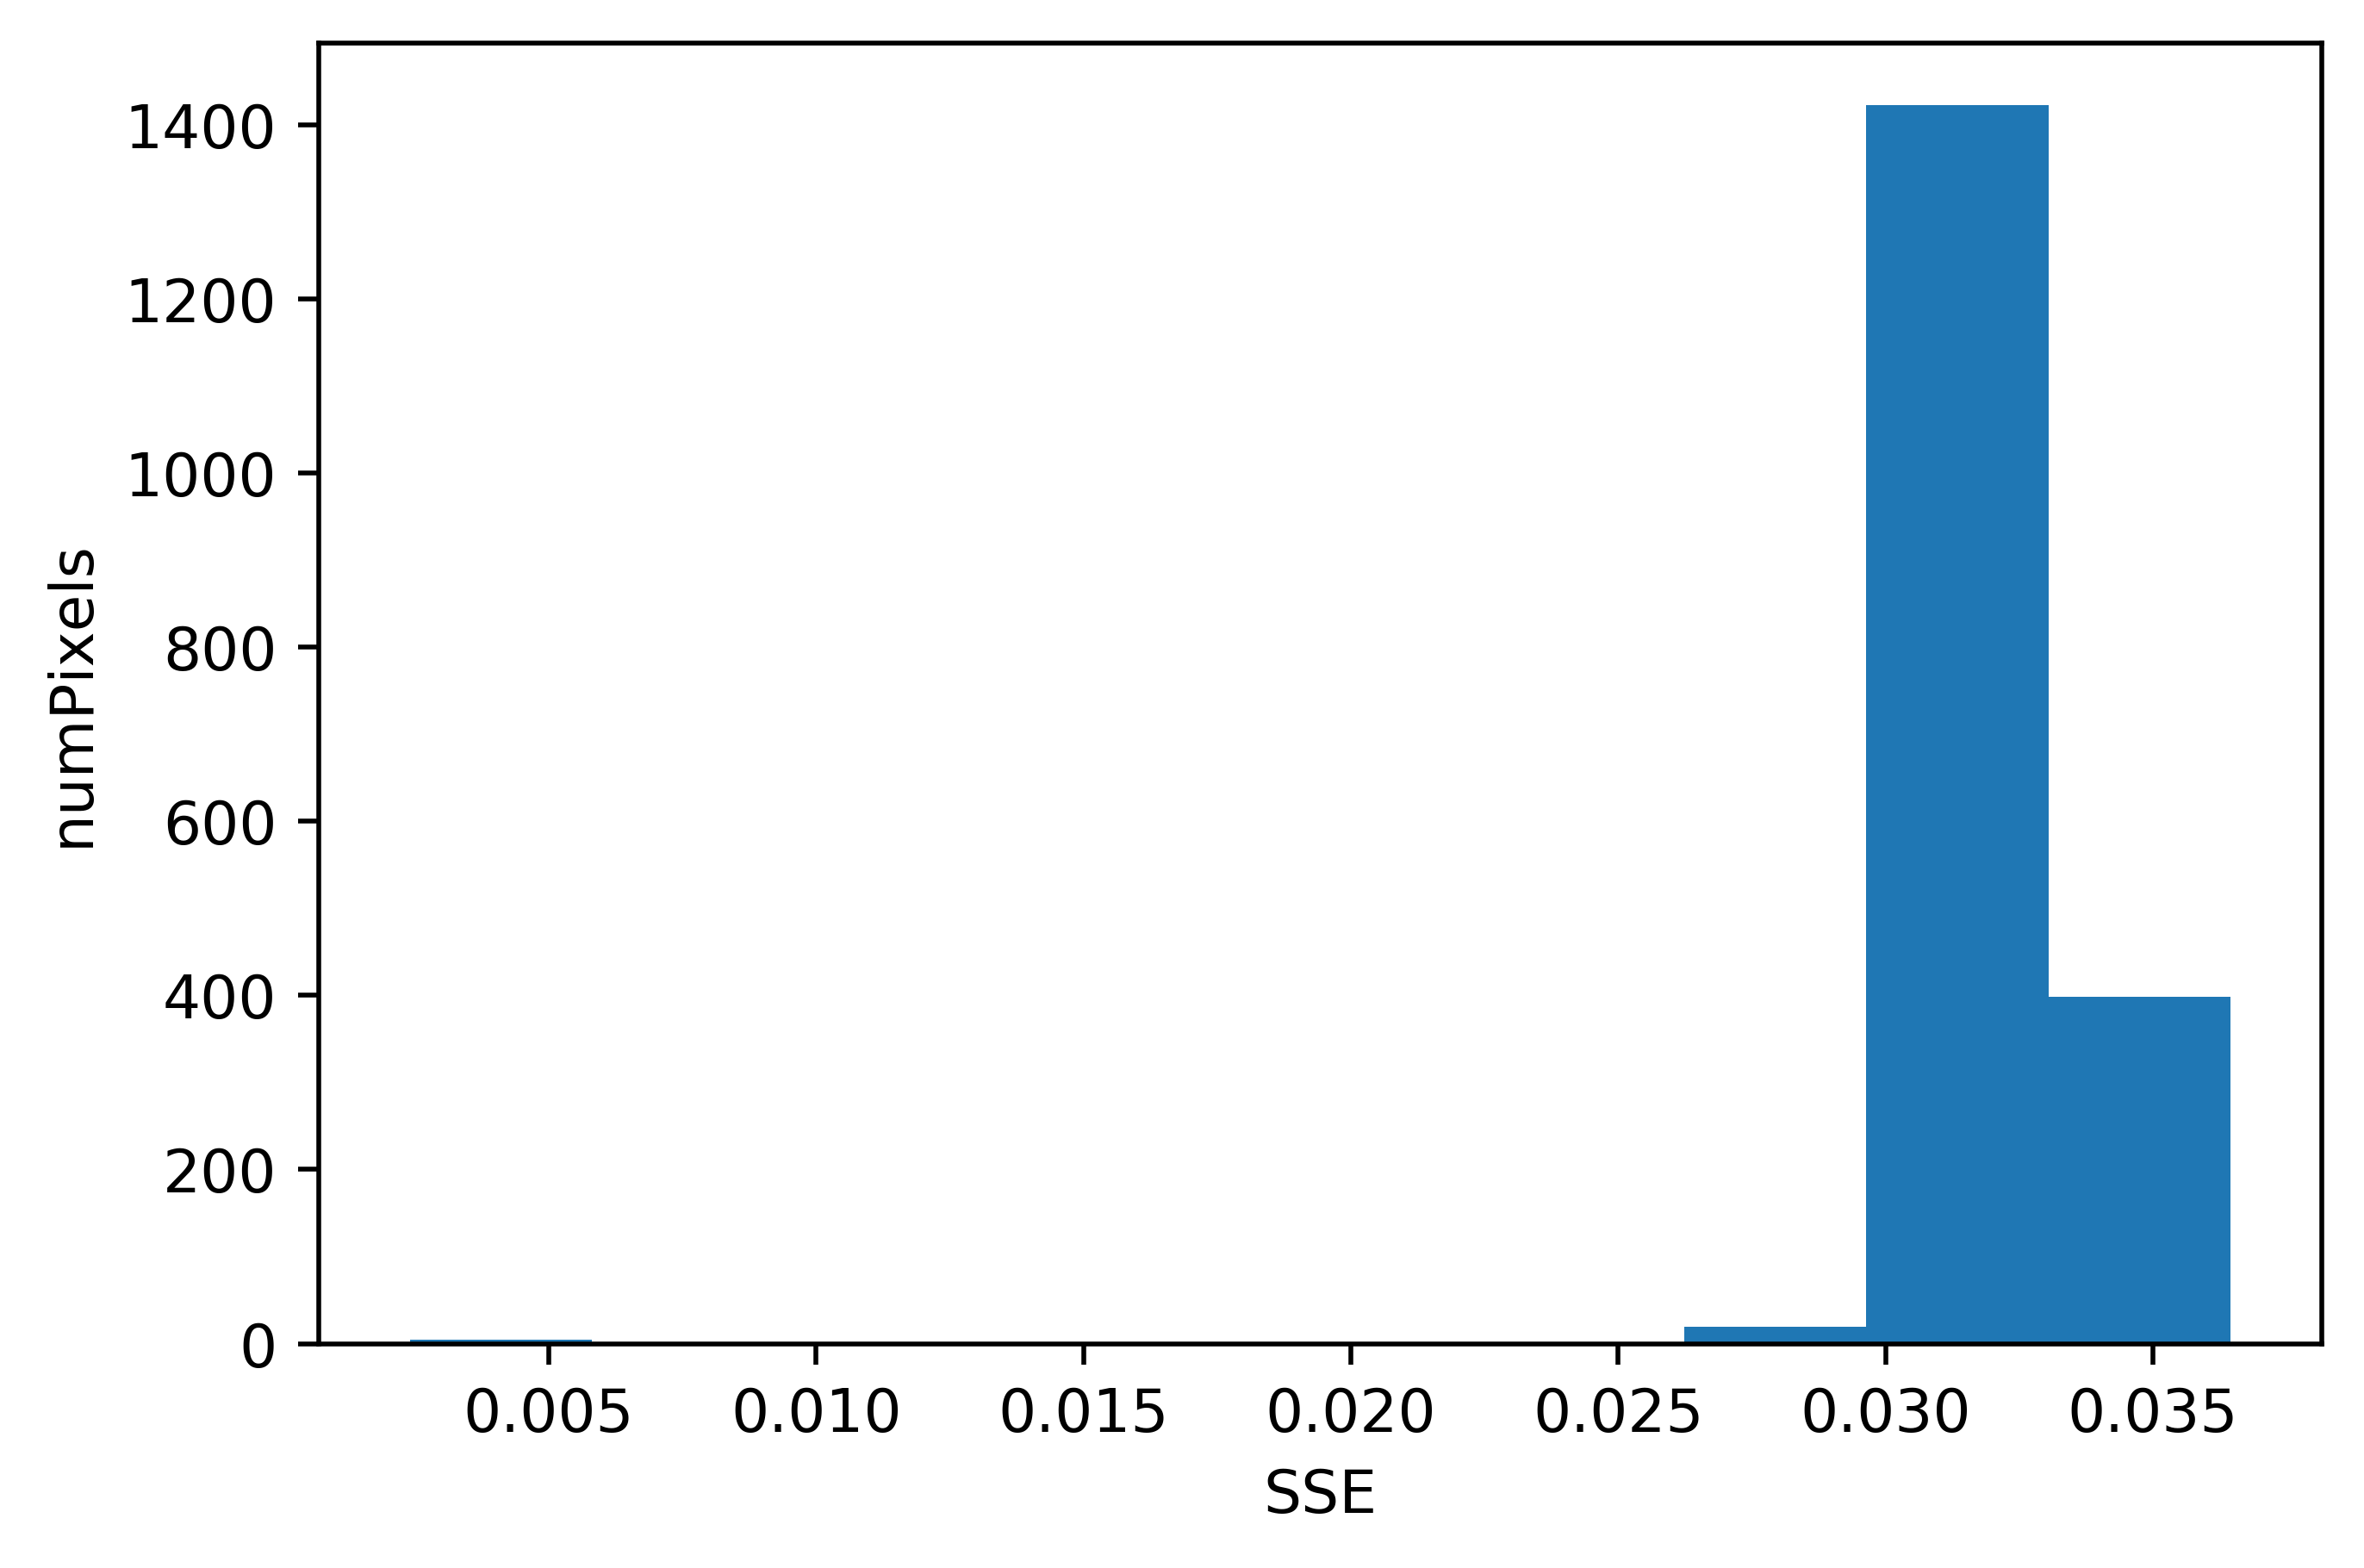

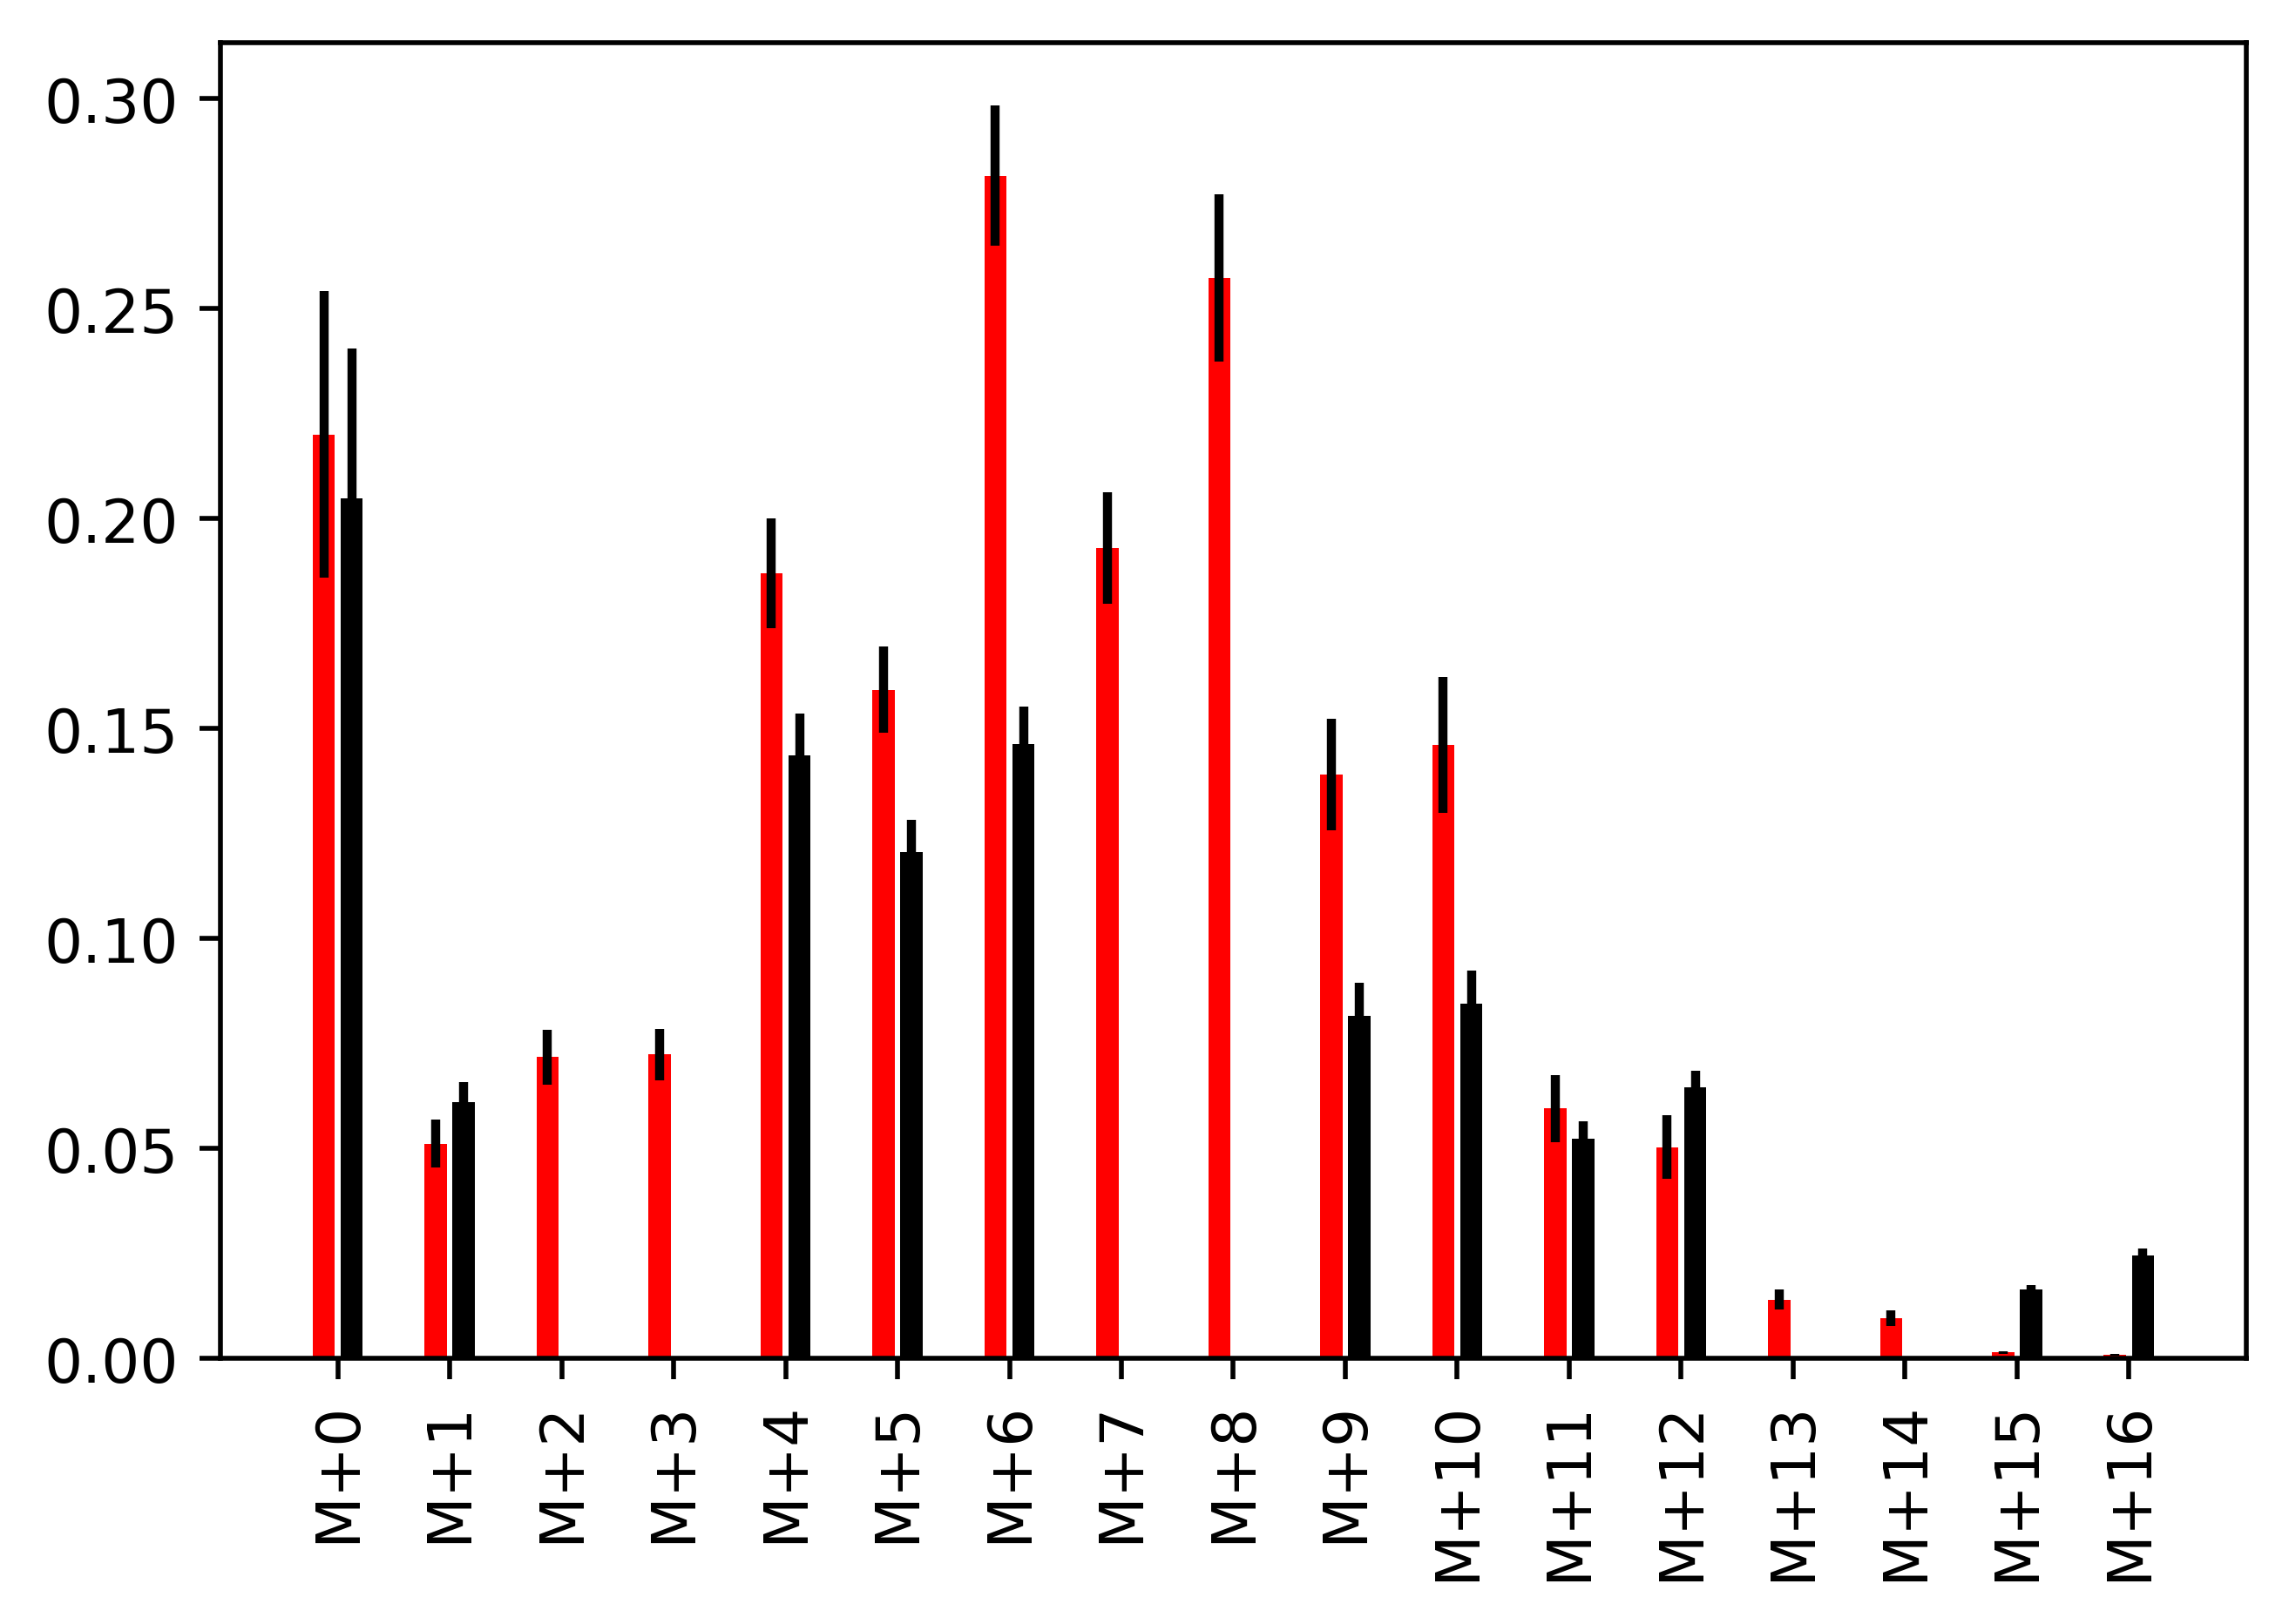

In [129]:
c13ab = 0.011
N = [(1-c13ab)**2,2*(1-c13ab)*c13ab,c13ab**2]
T = [0,0,1]
errs = []
T_founds = []
fluxImageG = np.zeros((len(tensorFilt[0]),len(tensorFilt[0][0])))
fluxImageD = np.zeros((len(tensorFilt[0]),len(tensorFilt[0][0])))
P_trues = []
P_preds = []

goodInd = []
for t in range(len(tensorFilt)):
    trel = tensorFilt[t][newImageBoundary > .5]
    if np.mean(trel) > 0.01:
        goodInd.append(t)

for r in range(len(tensorFilt[0])):
    for c in range(len(tensorFilt[0][0])):
        P = tensorFilt[:,r,c]
        if np.sum(P) > .5:
            g,D,T_found,err,P_pred = ISAFit(T,N,P,func,goodInd)
            errs.append(err)
            T_founds.append(T_found)
            P_trues.append(P)
            P_preds.append(P_pred)
        else:
            g,D = 0,0
        fluxImageG[r,c] = g
        fluxImageD[r,c] = D
        
plt.imshow(fluxImageG)
plt.colorbar()
plt.title("g")
plt.figure()
plt.imshow(fluxImageD)
plt.title("D")
plt.colorbar()
plt.figure()
plt.hist(errs)
plt.xlabel("SSE")
plt.ylabel("numPixels")
T_found = np.mean(T_founds,axis=0)/np.sum(np.mean(T_founds,axis=0))
print(T_found)

plt.figure()
x_ind = 0
x_lab = []
meanPred = np.mean(P_preds,axis=0)
stdPred = np.std(P_preds,axis=0)
meanTrue = np.mean(P_trues,axis=0)
stdTrue = np.std(P_trues,axis=0)
i = 0
for mP,sP,mT,sT in zip(meanPred,stdPred,meanTrue,stdTrue):
    plt.bar([x_ind,x_ind+1],[mP,mT],color=["red","black"],yerr = [sP,sT])
    x_lab.append([x_ind+.5,"M+" + str(i)])
    x_ind += 4
    i += 1
plt.xticks([x[0] for x in x_lab],[x[1] for x in x_lab],rotation=90);